# SOCI 415 Network Analysis - KINMATRIX Dataset

prAxIs UBC Team <br> *Alex Ronczewski*  
2025-08-24

# Prerequisites

SOCI 415 Network Anlysis Notebook

## KINMATRIX DATA DESCRIPTION

The KINMATRIX dataset represents families as ego-centric networks of
younger adults aged 25 to 35, collecting extensive data about both
nuclear and extended kin across ten countries. The data include over
12,000 anchor respondents and more than 252,000 anchor-kin dyads,
encompassing a wide range of relatives such as parents, siblings,
grandparents, aunts, uncles, cousins, and complex kin (e.g., step- and
half-relatives).

Anchor respondents refer to the ones directly sampled from. These
anchors filled out the survey about their families and kin meaning that
they will always be at the center of these family networks.

The countries in the dataset are the United Kingdom, Germany, Poland,
Italy, Sweeden, Denmark, Finland, Norway, the Netherlands and the USA.

### Part 1. Broader Patterns Across Countries

We will begin by looking at broader patterns across different countries.
This will serve as an introduction into the dataset and will be a
foundation for more focused analysis later on. First we import all the
necessary Python libraries for data manipulation, network analysis, and
visualization. This will allow us to get results for each country. The
output of this cell will be a list of countries in the data.

Import Libraries and the Data:

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches 
import networkx as nx 
import pandas as pd 
import numpy as np
import geopandas as gpd
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import community as community_louvain
import random
import plotly.graph_objects as go
from pyvis.network import Network
import re
import matplotlib.cm as cm

file_path = r'ZA8825_v1-0-0.dta' #path
df = pd.read_stata(file_path)

#Print country codes
print(df['anc_cou'].unique())

#Make a list of countries
country_dfs = {}
for country in df['anc_cou'].unique():
    country_dfs[country] = df[df['anc_cou'] == country]

#### 1.1 Make it a Network

Here, we systematically construct a kinship network for each country in
the dataset using the NetworkX Python package. For each country, we
filter the data, create a new graph, and add nodes representing anchor
individuals and their kin. Then we draw edges between the nodes.
Finally, we print out the number of nodes and edges for each country’s
network, providing a quick overview of network size and complexity
across the dataset.

In [2]:
#Set up a dictionary of countries
country_map = {
    'UK': '1. UK',
    'Germany': '2. Germany',
    'Poland': '3. Poland',
    'Italy': '4. Italy',
    'Sweden': '5. Sweden',
    'Denmark': '6. Denmark',
    'Finland': '7. Finland',
    'Norway': '8. Norway',
    'Netherlands': '9. Netherlands',
    'USA': '10. USA'
}
graphs = {}

for country, anc_cou_value in country_map.items():
    filtered_df = df[df['anc_cou'] == anc_cou_value]
    G_filtered = nx.Graph()
    
    # Add anchor nodes
    for idx, row in filtered_df.iterrows():
        G_filtered.add_node(row['anc_id'], 
                            country=row['anc_cou'],
                            age=row['anc_age'],
                            gender=row['anc_gnd'])
    
    # Add kin nodes and edges
    for idx, row in filtered_df.iterrows():
        kin_node = f"{row['anc_id']}_{row.get('kin_nam', 'unknown')}_{idx}"
        G_filtered.add_node(kin_node, relation=row.get('kin_rel1', None))
        G_filtered.add_edge(row['anc_id'], kin_node, relation=row.get('kin_rel1', None))
    
    # Store the graph and anchor nodes
    anchor_nodes = list(filtered_df['anc_id'].unique())
    graphs[country] = {
        'graph': G_filtered,
        'anchor_nodes': anchor_nodes
    }
    
    print(f"{country}:")
    print(f"  Number of nodes: {G_filtered.number_of_nodes()}")
    print(f"  Number of edges: {G_filtered.number_of_edges()}")
    print()

We can see that the Kinmatrix dataset has a wide range of networks
ranging from smaller countries like Norway and Denmark (~3000 Nodes) to
expansive networks like the United States with 118,702 nodes. This is a
good overview, but it does not really give any information on the nature
of the networks, their size, family relations and other interesting
statistics.

#### 1.2 Finding summary statistics across the countries

This block computes and displays key network statistics for each
country’s kinship network. We calculate the mean degree (average number
of connections per node), and the gender distribution among anchor
nodes.

In [3]:
for country, data in graphs.items():
    G = data['graph']
    anchor_nodes = data['anchor_nodes']
    
    # Mean degree for anchor nodes only
    anchor_degrees = [G.degree(n) for n in anchor_nodes]
    mean_anchor_degree = np.mean(anchor_degrees) if anchor_degrees else 0
    
    # Gender distribution among anchor nodes
    female_count = sum(1 for n in anchor_nodes if G.nodes[n].get('gender') == '2. Female')
    male_count = sum(1 for n in anchor_nodes if G.nodes[n].get('gender') == '1. Male')
    other_count = sum(1 for n in anchor_nodes if G.nodes[n].get('gender') == '3. Other gender or no gender')
    
    print(f"{country}:")
    print(f"  Mean degree (anchor nodes): {mean_anchor_degree:.2f}")
    print(f"  Female anchor nodes: {female_count}")
    print(f"  Male anchor nodes: {male_count}")
    print(f"  Other/No gender anchor nodes: {other_count}")
    print()

The results are interesting we can see that the smallest family networks
are in Germany (16.33 nodes per anchor) and the largest are in the
United States (22.72 nodes per anchor). We can also see that there are
more women than men in most countries espcially in the US (2,992 women
compared to 1,956 men).

#### 1.3 Pyvis Visualization for Norway

Here we have enough information to do a visualization of our findings.
We will use the Pyvis package. This package will make an interactive
visualization which you can zoom in and pan around. This will be the
most simple visualization we will make, and it will just be on the shape
and size of the network. The code loads the NetworkX graph into Pyvis,
cleans any missing attribute values, and provides interactive controls
for exploring the network.

In [4]:
# Retrieve the Norway Network
G_Norway = graphs['Norway']['graph']
anchor_nodes_norway = graphs['Norway']['anchor_nodes']

# Clean None attributes
for n, attrs in G_Norway.nodes(data=True):
    for k, v in attrs.items():
        if v is None:
            G_Norway.nodes[n][k] = "NA"

for u, v, attrs in G_Norway.edges(data=True):
    for k, val in attrs.items():
        if val is None:
            G_Norway.edges[u, v][k] = "NA"

# Create a new Pyvis Network
net = Network(height='800px', width='100%', notebook=True)

# Create simple anchor mapping
anchor_to_label = {}
for i, anchor in enumerate(anchor_nodes_norway, 1):
    anchor_to_label[anchor] = f"Anchor-{i}"

# Add nodes manually 
for node in G_Norway.nodes():
    if node in anchor_nodes_norway:
        # Anchor nodes with labels
        net.add_node(node, label=anchor_to_label[node], color='#4ECDC4', size=15)
    else:
        # Kin nodes
        net.add_node(node, color='#4ECDC4', size=8)

# Add edges manually
for u, v in G_Norway.edges():
    net.add_edge(u, v)

for node in net.nodes:
    if node['id'] not in anchor_nodes_norway:
        node['label'] = '' 

# Minimal settings
net.show('norway_updated_network.html')

print("All blue nodes version saved as 'norway_all_blue_nodes.html'")
print(f"Total nodes: {G_Norway.number_of_nodes()}")
print(f"Total edges: {G_Norway.number_of_edges()}")
print(f"Anchor nodes labeled: {len(anchor_nodes_norway)}")

### 2. Density by Age and Gender Across Countries

This code block constructs kinship network graphs for each country in
the KINMATRIX dataset and then analyzes how the number of nodes in the
family networks vary by age and gender within each country. This
analysis helps reveal patterns and differences in family network
structure across demographic groups and between countries, providing
insight into how kinship connectivity varies by age and gender in
different countries.

In [5]:
graphs = {}

for country, anc_cou_value in country_map.items():
    filtered_df = df[df['anc_cou'] == anc_cou_value]
    G_filtered = nx.Graph()
    
    # Add anchor nodes
    for idx, row in filtered_df.iterrows():
        G_filtered.add_node(row['anc_id'], 
                            country=row['anc_cou'],
                            age=row['anc_age'],
                            gender=row['anc_gnd'])
    
    # Add kin nodes and edges
    for idx, row in filtered_df.iterrows():
        kin_node = f"{row['anc_id']}_{row.get('kin_nam', 'unknown')}_{idx}"
        G_filtered.add_node(kin_node, relation=row.get('kin_rel1', None))
        G_filtered.add_edge(row['anc_id'], kin_node, relation=row.get('kin_rel1', None))

    graphs[country] = G_filtered

def analyze_family_degree_by_demographics(G_filtered):
    degree_by_age = {}
    degree_by_gender = {}

    # Identify anchor nodes by prerequisite attribute
    anchor_nodes = [n for n, d in G_filtered.nodes(data=True)
                    if ('age' in d and 'gender' in d)]

    for anchor_id in anchor_nodes:
        # Degree of the anchor node (number of kin ties)
        deg = G_filtered.degree(anchor_id)
        age = G_filtered.nodes[anchor_id].get('age')
        gender = G_filtered.nodes[anchor_id].get('gender')

        if age is not None:
            age_group = age // 10 * 10  
            degree_by_age.setdefault(age_group, []).append(deg)
        if gender is not None:
            degree_by_gender.setdefault(gender, []).append(deg)

    print("Mean Degree by Age Group:")
    for age_group, degrees in sorted(degree_by_age.items()):
        print(f"  Age {age_group}s: Mean Degree = {np.mean(degrees):.2f}, Count = {len(degrees)}")

    print("\nMean Degree by Gender:")
    for gender, degrees in degree_by_gender.items():
        print(f"  Gender {gender}: Mean Degree = {np.mean(degrees):.2f}, Count = {len(degrees)}")

#Show results
for country in country_map:
    if country in graphs:
        print(f"\n--- {country} ---")
        analyze_family_degree_by_demographics(graphs[country])
    else:
        print(f"No graph available for {country}")

#### 2.1 Finding a Pattern

Interactive part: Have a look at our findings from sections 1 and 2,
based on frameworks taught in class explain a reason for them.

Some example findings are listed below, you can try to answer these 3,
or look for your own and try to link it to a concept from class.

1.  Age does not seem to be a factor in mean degree. In six out of ten
    countries, anchors in their 20’s have a higher degree than anchors
    in their 30’s. Why is this, we would expect older anchors to have
    larger families?
2.  Women tend to have a higher mean degree than men in all countries
    (Poland: Male = 17.97, Female = 20.25). Why is this?
3.  The USA has the largest mean degree out of all countries in the
    dataset by both age and gender. Is it purely because of the large
    sample size in the US or are there other factors? We might expect
    the US to have a lower mean degree especially among anchors aged
    20-30 as their parents or grandparents are likely to be immigrants
    disconnected from their families in their original countries.

# 3.0 Colored Family Networks

For the next part of the notebook we have decided to focus on the
Pomeranian (Pomorskie in Polish) Voivodeship in north-western Poland
with the largest city being Gdańsk. 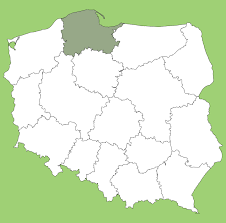 It has a population of 2.24
million as of 2019.

The code below will filter our data for Poland and the Pomorskie region
to have a smaller subset.

In [6]:
filtered_df = df[(df['anc_cou'] == '3. Poland') & (df['anc_regpl'] == '11. Pomorskie')] #Filter anc_cou to be Poland and anc_regpl to be Pomorskie
#print(filtered_df.head())
print(f"Number of rows after filtering: {len(filtered_df)}")

### 3.1 Make it a NetworkX Network

The code below makes a new NetworkX relationship with anchors (highest
level of a family ancestor) and their kin. The output will be the total
number of nodes and edges in the Network.

In [7]:
G_filtered = nx.Graph()

# Add anchor nodes for filtered data
for idx, row in filtered_df.iterrows():
    G_filtered.add_node(row['anc_id'], 
                        country=row['anc_cou'],
                        age=row['anc_age'],
                        gender=row['anc_gnd'])

# Add kin nodes and edges 
for idx, row in filtered_df.iterrows():
    kin_node = f"{row['anc_id']}_{row.get('kin_nam', 'unknown')}_{idx}"
    G_filtered.add_node(kin_node, relation=row.get('kin_rel1', None))
    G_filtered.add_edge(row['anc_id'], kin_node, relation=row.get('kin_rel1', None))

# Define anchor_nodes
anchor_nodes = list(filtered_df['anc_id'].unique())

print(f"Number of nodes: {G_filtered.number_of_nodes()}")
print(f"Number of edges: {G_filtered.number_of_edges()}")

The Network in the Pomorskie region of Poland is quite small with 2414
nodes meaning that we can easily visualize it without running into
computational problems.

### 3.2 Colored Visualization

We will make a Pyvis visualization with coloring for family structures.
This will again be an interactive visualization where you will be able
to pan and zoom. Another feature is that you can hover over nodes to see
their gender,

Below we will have a legend of the relationships.

In [8]:
# Define color map for main relationship types
relationship_colors = {
    'father': 'blue',
    'mother': 'pink',
    'brother': 'green',
    'sister': 'purple',
    'aunt': 'orange',
    'uncle': 'brown',
    'cousin': 'teal',
    'grandfather': 'navy',
    'grandmother': 'magenta',
    'son': 'red',
    'daughter': 'yellow',
    'nephew': 'lightgreen',
    'niece': 'lightpink',
    'stepfather': 'slateblue',
    'stepmother': 'plum',
    'other': 'gray',
}

def extract_relation(rel_str):
    if not isinstance(rel_str, str):
        return 'other'
    rel_str = rel_str.lower()
    # Remove the number prefix
    rel_str = re.sub(r'^\d+\.\s*', '', rel_str)
    
    # Find all matching relationship keywords with word boundaries and return the last one
    found_relations = []
    
    # Sort relationship keys by length
    sorted_keys = sorted(relationship_colors.keys(), key=len, reverse=True)
    
    for key in sorted_keys:
        if key == 'other':
            continue
        # Use word boundaries to match complete words only
        pattern = r'\b' + re.escape(key) + r'\b'
        matches = list(re.finditer(pattern, rel_str))
        for match in matches:
            found_relations.append((match.start(), key))
    
    if found_relations:
        # Sort by position and return the last one
        found_relations.sort(key=lambda x: x[0])
        return found_relations[-1][1]
    
    return 'other'

# Create a new Pyvis Network
net = Network(height='800px', width='100%', notebook=True, bgcolor='#ffffff', font_color='black')

# Create anchor mapping for cleaner labels
anchor_to_label = {}
anchor_nodes = list(filtered_df['anc_id'].unique())
for i, anchor in enumerate(anchor_nodes, 1):
    anchor_to_label[anchor] = f"Anchor-{i}"

# Add anchor nodes with clean labels
for idx, row in filtered_df.iterrows():
    net.add_node(row['anc_id'],
                 label=anchor_to_label[row['anc_id']],  
                 color='lightblue',  
                 size=15,  
                 title=f"Age: {row['anc_age']}<br>Gender: {row['anc_gnd']}")

# Add kin nodes and edges with relationship-based coloring
for idx, row in filtered_df.iterrows():
    relation_raw = row.get('kin_typ', None)  
    relation = extract_relation(relation_raw)
    color = relationship_colors.get(relation, 'gray')
    kin_node = f"{row['anc_id']}_{row.get('kin_nam', 'unknown')}_{idx}"
    
    # Add kin node with temporary label (will be removed later)
    net.add_node(kin_node,
                 label=str(row.get('kin_nam', 'unknown')),  # Temporary label
                 color=color,
                 size=8,  # Smaller size for kin nodes
                 title=f"Relation: {relation_raw}")  # Hover info stays
    
    net.add_edge(row['anc_id'], kin_node, title=relation_raw)

for node in net.nodes:
    if node['id'] not in anchor_nodes:
        node['label'] = ''  # Empty label for kin nodes - no labels when zoomed in

net.show_buttons()
net.show('family_structure_network.html')

patches = [mpatches.Patch(color=color, label=relation) for relation, color in relationship_colors.items()]

# Plot the legend of family relations in the cell output
fig, ax = plt.subplots(figsize=(6, 4))
ax.legend(handles=patches, loc='center', frameon=False, fontsize=10)
ax.axis('off')
plt.show()

When looking at the visualization you can hover over the nodes for more
family information, or you can look at the color legend printed just
below the visualization. When hovering over a node you will see strings
similar to “Relation: 100. Father - Aunt 2 - Cousin 1.” At first this
might seem confusing, that a single node can have three relations
assosiated with it. To explain the bizzare relationship structures lets
print out the relationships to understand what’s going on.

In [9]:
# Build a table of anchor-label, kin-name, relationship string, and extracted main type
relationship_table = []

for idx, row in filtered_df.iterrows():
    anchor_label = anchor_to_label.get(row['anc_id'], str(row['anc_id']))
    kin_name = row.get('kin_nam', 'unknown')
    rel_str = row.get('kin_typ', '')
    main_relation = extract_relation(rel_str)
    relationship_table.append({
        'Anchor': anchor_label,
        'Kin Name': kin_name,
        'Relationship(s)': rel_str,
        'Main Relation': main_relation
    })

rel_df = pd.DataFrame(relationship_table)
# Display first 20 rows for quick inspection
print(rel_df.head(20).to_string(index=False))

This makes things more clear. For example: the label “245. Mother -
Grandfather” means: this kin is reached via the anchor’s “mother” and
then her “grandfather.”

Another example is: “145. Father - Aunt 1 - Cousin 1” which means: this
relative is a cousin through the anchor’s father’s aunt.

These strings are traversals through the family tree of the anchor
individual. The most important is the last term for these two examples
“Grandfather” and “Cousin,” these are family role that the node has from
the anchors persepctive. The first one is the anchors Grandfather on his
mothers side and the second one is his cousin from his father’s side.

# 3.3 In class discussion from the family structures visualization

Students will look at the visualization on their browser and in small
groups of 3-4 will discuss how the findings from this dataset can be
linked to theories in studied frameworks from the course. After about 10
minuites of discussion groups will state their most interesting or best
interpretation that they found, some possible examples are listed below
for the Social Exchange Framework, and the Feminist Framework.

**Social Exchange Framework** Family ties exist as a exchange of
resources so each edge between the nodes means there is some form of
exchange, this could range from such as support, care, or obligation.
The color-coding of relationships (e.g., blue for father, pink for
mother) visually distinguishes different types of exchanges, allowing
analysis of who is connected to whom and what kinds of resources or
support might flow along those ties. For example, a node with many blue
(father) and pink (mother) connections might receive more parental
support, while green (brother) or purple (sister) ties could represent
sibling exchanges.

**Feminist Framework**

The feminist framework examines gender roles, power imbalances, and the
ways traditional family structures reinforce gender inequality. For
example we can link the centrality or marginalization of female roles
(e.g., mothers, daughters, sisters) compared to male roles (fathers,
sons, brothers) to patriarchical structures of modern western society.

# 4.0 Visualization of Gender

Below the code will make an interactive Pyvis visualization with dots
colored for gender. This can be used to discuss gender compositions of
families and feminist theory. We can see if our network supports the
theory of power imbalances and reflect the ways traditional family
structures reinforce gender inequality.

In [10]:
#Relationship mapping
GENDER_FROM_RELATIONSHIP = {
    # Male relationships
    'father': 'male', 'dad': 'male', 'daddy': 'male', 'papa': 'male',
    'son': 'male', 'brother': 'male', 'grandfather': 'male', 'grandpa': 'male',
    'uncle': 'male', 'nephew': 'male', 'husband': 'male', 'boyfriend': 'male',
    'stepfather': 'male', 'stepson': 'male', 'stepbrother': 'male',
    'father-in-law': 'male', 'son-in-law': 'male', 'brother-in-law': 'male',
    'godfather': 'male', 'godson': 'male',
    
    # Female relationships
    'mother': 'female', 'mom': 'female', 'mommy': 'female', 'mama': 'female',
    'daughter': 'female', 'sister': 'female', 'grandmother': 'female', 'grandma': 'female',
    'aunt': 'female', 'niece': 'female', 'wife': 'female', 'girlfriend': 'female',
    'stepmother': 'female', 'stepdaughter': 'female', 'stepsister': 'female',
    'mother-in-law': 'female', 'daughter-in-law': 'female', 'sister-in-law': 'female',
    'godmother': 'female', 'goddaughter': 'female'
}

#Function to get gender color from node
def get_node_gender_and_color(row, is_anchor=True):
    # Gender color mapping
    colors = {'male': 'purple', 'female': 'yellow', 'unknown': 'green'} 
    
    if is_anchor:
        # For anchor nodes
        gender_field = str(row.get('anc_gnd', '')).lower().strip()
        
        # Handle various gender field formats
        if gender_field in ['m', 'male', 'man', '1. male', '1.male', 'male.', '1']:
            return 'male', colors['male']
        elif gender_field in ['f', 'female', 'woman', '2. female', '2.female', 'female.', '2']:
            return 'female', colors['female']
        elif 'male' in gender_field and 'female' not in gender_field:
            return 'male', colors['male']
        elif 'female' in gender_field:
            return 'female', colors['female']
    else:
        # For kin nodes
        gender_field = str(row.get('kin_gnd', '')).lower().strip()
        
        # Handle various gender field formats for kin nodes too
        if gender_field in ['m', 'male', 'man', '1. male', '1.male', 'male.', '1']:
            return 'male', colors['male']
        elif gender_field in ['f', 'female', 'woman', '2. female', '2.female', 'female.', '2']:
            return 'female', colors['female']
        elif 'male' in gender_field and 'female' not in gender_field:
            return 'male', colors['male']
        elif 'female' in gender_field:
            return 'female', colors['female']
        
        # Get gender from relationship if direct gender field doesn't work
        relationship = str(row.get('kin_typ', '')).lower().strip()
        # Clean the relationship string
        relationship = re.sub(r'^(my|the|a|an)\s+', '', relationship)
        
        # Check for relationship matches
        for rel_key, gender in GENDER_FROM_RELATIONSHIP.items():
            if rel_key in relationship or relationship in rel_key:
                return gender, colors[gender]
    
    return 'unknown', colors['unknown']

# Initialize your network
net = Network(height="600px", width="100%", bgcolor="#ffffff", font_color="black", notebook=True)

# Create anchor mapping for cleaner labels
anchor_to_label = {}
anchor_nodes = list(filtered_df['anc_id'].unique())
for i, anchor in enumerate(anchor_nodes, 1):
    anchor_to_label[anchor] = f"Anchor-{i}"

# Add anchor nodes with gender-based coloring and only gender in hover
print("Adding anchor nodes with gender colors...")
for idx, row in filtered_df.iterrows():
    gender, color = get_node_gender_and_color(row, is_anchor=True)
    net.add_node(row['anc_id'],
                 label=anchor_to_label[row['anc_id']],  # Clean "Anchor-X" label
                 color=color,
                 size=15,  # Larger size for anchor nodes
                 title=f"Gender: {gender}")  # Only gender in hover

# Add kin nodes and edges with gender-based coloring
print("Adding kin nodes with gender colors...")
for idx, row in filtered_df.iterrows():
    gender, color = get_node_gender_and_color(row, is_anchor=False)
    kin_node = f"{row['anc_id']}_{row.get('kin_nam', 'unknown')}_{idx}"
    
    net.add_node(kin_node,
                 label='',  # No label for kin nodes
                 color=color,
                 size=8,  # Smaller size for kin nodes
                 title=f"Gender: {gender}")  # Only gender in hover
    
    # Add edge between anchor and kin (no title/hover info on edges)
    net.add_edge(row['anc_id'], kin_node)

# Remove labels from kin nodes (keep only anchor node labels)
for node in net.nodes:
    if node['id'] not in anchor_nodes:
        node['label'] = ''  # Empty label for kin nodes

# Configure and display network
net.show_buttons(filter_=['physics'])
net.show('cdn_gender_only_kinship_network_fixed.html')
print("Network created successfully with gender-only hover info!")

# Print summary of node colors
node_colors = {}
for node in net.nodes:
    color = node['color']
    node_colors[color] = node_colors.get(color, 0) + 1

print("\nNode color summary:")
color_to_gender = {'purple': 'Male', 'yellow': 'Female', 'green': 'Unknown'}
for color, count in node_colors.items():
    gender_name = color_to_gender.get(color, color)
    print(f"  {gender_name}: {count} nodes")

print(f"\nNetwork summary:")
print(f"- Total nodes: {len(net.nodes)}")
print(f"- Total edges: {len(net.edges)}")
print(f"- Anchor nodes labeled: {len(anchor_nodes)}")
print(f"- Kin nodes: {len(net.nodes) - len(anchor_nodes)} (no labels)")

The color scheme we are using is male are purple, women are yellow and
other/unknown gender individuals are colored as green.

# 5.0 Health and Education Across Countries

The KINMATRIX Dataset is not just limited to information about family
relations, during the data gathering process researches also asked about
socio-economic variables like education, employment, health, sexuality
and religion. Our goal for this section is to look at Health and
Education across the ten countries in the dataset. These metrics are
based on surveys of anchor individuals. These are subjective measures
which can change from country to country, the goal is to look if there
are differences between countries which we can infer from the data that
causes these differences in health and education. We should not expect
these findings to reflect findings in censuses, or large cross country
surveys of health and education as that was not the purpose of the
KINMATRIX Dataset.

### 5.1 Health and Education Variables

When doing any analysis it’s important to be familiar with the
varaibles. In this case we are looking at Health and Education which are
`anc_hea` and `anc_eduall`. Below we will print out all possible values
these variables can take and the count of responces for each.

In [11]:
print("All possible values in 'anc_hea':")
print(df['anc_hea'].value_counts(dropna=False), end='\n\n')

print("All possible values in 'anc_eduall':")
print(df['anc_eduall'].value_counts(dropna=False))

`anc_hea`: This variable which stands for the anchor person’s self-rated
health. The possible values represent subjective categories ranging from
Very Good to Very Bad health. We can see most people in the dataset are
in good health with few in Bad or Very Bad health.

`anc_eduall`: This variable represents the anchor person’s overall level
of education, classified into three levels and an option for
non-response. We can see most people in the dataset have high education.
We will find out about why later on.

The way in which we will define healthy is if the respondant says his
health is either “Very Good” or “Good.” As for edcuation we will define
some who is educated if they answered the “High Responce.”

The Code block below will look through all countries and find most and
least educated and most and least healthy.

In [12]:
# Country mapping dictionary
country_map = {
    'UK': '1. UK',
    'Germany': '2. Germany',
    'Poland': '3. Poland',
    'Italy': '4. Italy',
    'Sweden': '5. Sweden',
    'Denmark': '6. Denmark',
    'Finland': '7. Finland',
    'Norway': '8. Norway',
    'Netherlands': '9. Netherlands',
    'USA': '10. USA'
}

# Initialize results storage
health_results = {}
education_results = {}

# Calculate percentages for each country
for country, code in country_map.items():
    country_df = df[df['anc_cou'] == code]
    
    # Health calculation
    health_counts = country_df['anc_hea'].value_counts(dropna=True)
    very_good = health_counts.get('1. Very good', 0)
    good = health_counts.get('2. Good', 0)
    total_health = health_counts.sum()
    health_pct = (very_good + good) / total_health if total_health > 0 else 0
    health_results[country] = health_pct
    
    # Education calculation
    edu_counts = country_df['anc_eduall'].value_counts(dropna=True)
    high_edu = edu_counts.get('3. High', 0)
    # Exclude 'Prefer not to answer' from total
    valid_responses = edu_counts.drop('-2. Prefer not to answer', errors='ignore').sum()
    edu_pct = high_edu / valid_responses if valid_responses > 0 else 0
    education_results[country] = edu_pct

# Sort results from most to least
sorted_health_desc = sorted(health_results.items(), key=lambda x: x[1], reverse=True)
sorted_education_desc = sorted(education_results.items(), key=lambda x: x[1], reverse=True)

# Prepare output strings
health_output = "Countries sorted by health (most to least healthy):\n"
edu_output = "Countries sorted by education (most to least educated):\n"

for country, pct in sorted_health_desc:
    health_output += f"{country}: {pct:.2%}\n"

for country, pct in sorted_education_desc:
    edu_output += f"{country}: {pct:.2%}\n"

print(health_output)
print(edu_output)

We can see that the finding may be suprising for most people. The United
States being the most educated and Germany being the least does seem
strange at first glace, but these findings are correct according to the
data.

The reason for these findings are the sampling methodoly used by the
Researchers. In the [Methods
Report](https://www.demographic-research.org/volumes/vol51/25/51-25.pdf),
we can find that the KINMATRIX researchers explicitly acknowledge that
their data shows “Substantial underrepresentation of lower-educated
people in all countries” and “No accurate representation of country
differences across intermediate and higher education levels” (8). This
is inflating the higher education percentages across the countries in
our dataset. Because of the nature of education this bias towards higher
education also “extends also to their parental background” (14) and
further.

Another reason for this is bias is the manner in which the data was
collected. The key reason is that the researchers did not do random
sampling, but rather quota sampling from Dynata access panels which
hosted an online survey. This method may lead to the exclusion of people
without internet/computer and there was no mobile access. This is a
known limitation of web-based, non-probability sampling that affects
social surveys and the researchers are aware of it.

As for the health section the bias is less clear here, but the health
results show similar patterns because higher-educated people are both
more likely to report good health and more likely to participate in
online surveys, creating a “double selection” effect.

# 6.0 Family size vs Politics in USA and Poland

You might have heard in politics and online that right-wing politics is
family oriented and conservatives have larger families with more
children. This is a common claim but is there empirical evidence to back
it up?

In the United States researchers have found that right-leaning
individuals tend to have larger families and more children than their
left-leaning counterparts, with evidence spanning multiple decades and
geographic regions. Republican leaning high-school seniors from
1989-2019 desired more children than their Democrat leaning peers.

As for actual statistics of childbirth between Republican and Democrat
states. Analysis of U.S. birth rates reveals that 100 conservative
adults raise 208 children on average, compared to 147 for democrats this
is a 41% gap which is very significant. Post-2016, Republican-majority
counties saw 7,000 more births than expected, while Democratic counties
had 38,000 fewer.

There is substantial evidence to conclude that Republican states should
have larger families with more children than their Democrat
counterparts, but does this track in the KINMATRIX data.

### 6.1 Republican and Democrat States

The way in which KINMATRIX categories US states is in regions. The
regions are New England, South Atlantic, Mid-Atlantic, East South
Central, East North Central, Pacific, West South Central, Mountain, and
West North Central. Based on these regions and the Cook Partisan Voting
Index (PVI).

The Democrat regions are:

-   New England (CT, MA, ME, NH, RI, VT)’,
-   Pacific (AK, CA, HI, OR, WA)’,
-   Mid-Atlantic (NJ, NY, DE, PA)’,
-   East North Central (IL, IN, MI, OH, WI)’

The Republican Regions are:

-   East South Central (AL, KY, MS, TN)’,
-   West South Central (AR, LA, OK, TX)’,
-   West North Central (IA, KS, MN, MO, NE, ND, SD)’,
-   Mountain (AZ, CO, ID, MT, NV, NM, UT, WY)’,
-   South Atlantic (FL, GA, MD, NC, SC, VA, WV, DC)’

The output of this code block will be the average size of families in
these regions.

In [13]:
# Extract US data from country_dfs and make a proper copy
us_data = country_dfs['10. USA'].copy()  

# Map region names to political lean
democrat_regions = [
    '5. New England (CT, MA, ME, NH, RI, VT)',
    '6. Pacific (AK, CA, HI, OR, WA)',
    '3. Mid-Atlantic (NJ, NY, DE, PA)',
    '1. East North Central (IL, IN, MI, OH, WI)'
]

republican_regions = [
    '2. East South Central (AL, KY, MS, TN)',
    '9. West South Central (AR, LA, OK, TX)',
    '8. West North Central (IA, KS, MN, MO, NE, ND, SD)',
    '4. Mountain (AZ, CO, ID, MT, NV, NM, UT, WY)',
    '7. South Atlantic (FL, GA, MD, NC, SC, VA, WV, DC)'
]

# Define color map for main relationship types
relationship_colors = {
    'father': 'blue',
    'mother': 'pink',
    'brother': 'green',
    'sister': 'purple',
    'aunt': 'orange',
    'uncle': 'brown',
    'cousin': 'teal',
    'grandfather': 'navy',
    'grandmother': 'magenta',
    'son': 'red',
    'daughter': 'yellow',
    'nephew': 'lightgreen',
    'niece': 'lightpink',
    'stepfather': 'slateblue',
    'stepmother': 'plum',
    'other': 'gray',
}

# Assign group based on region
def assign_state_group(region):
    if region in democrat_regions:
        return 'Democrat'
    elif region in republican_regions:
        return 'Republican'
    else:
        return 'Other'

# Define relationship extraction function
def extract_relation(rel_str):
    if not isinstance(rel_str, str):
        return 'other'
    rel_str = rel_str.lower()
    rel_str = re.sub(r'^\d+\.\s*', '', rel_str)
    for key in relationship_colors.keys():
        if key in rel_str:
            return key
    return 'other'

# Apply transformations
us_data['state_group'] = us_data['anc_regus'].apply(assign_state_group)
us_data['relation'] = us_data['kin_typ'].apply(extract_relation)


def calculate_metrics(group_data):
    kin_counts = group_data.groupby('anc_id').size()
    avg_kin = kin_counts.mean() if not kin_counts.empty else 0
    
    # Use the normalized relation column instead of string matching on kin_typ
    children = group_data[group_data['relation'].isin(['son', 'daughter'])]
    children_count = children.groupby('anc_id').size()
    avg_children = children_count.mean() if not children_count.empty else 0
    
    cluster_sizes = kin_counts + 1  # Anchor + kin count
    avg_cluster_size = cluster_sizes.mean() if not cluster_sizes.empty else 0
    return avg_kin, avg_children, avg_cluster_size

# Calculate results
results = {}
for group in ['Republican', 'Democrat']:
    group_data = us_data[us_data['state_group'] == group]
    avg_kin, avg_children, avg_cluster_size = calculate_metrics(group_data)
    results[group] = {
        'avg_kin_per_anchor': avg_kin,
        'avg_children_per_anchor': avg_children,
        'avg_cluster_size': avg_cluster_size
    }

# Overall in the US
avg_kin, avg_children, avg_cluster_size = calculate_metrics(us_data)
results['Overall US'] = {
    'avg_kin_per_anchor': avg_kin,
    'avg_children_per_anchor': avg_children,
    'avg_cluster_size': avg_cluster_size
}

# print results
for group, metrics in results.items():
    print(f"{group} Regions:")
    print(f"  Avg kin per anchor: {metrics['avg_kin_per_anchor']:.2f}")

The main findings are consistent with the theory discussed above. From
the KINMATRIX data of the 118,702 Nodes in the United States. Republican
regions on average have larger families of 23.91 versus 22.33 in
Democrat regions. This is a difference of 1.58.

### 6.2 Politics for Poland

The administrative Regions for Poland in KINMATRIX is voivodeships.
There are 16 voivodeships in Poland and they are the largest
administrative regions similar to provinces in Canada. 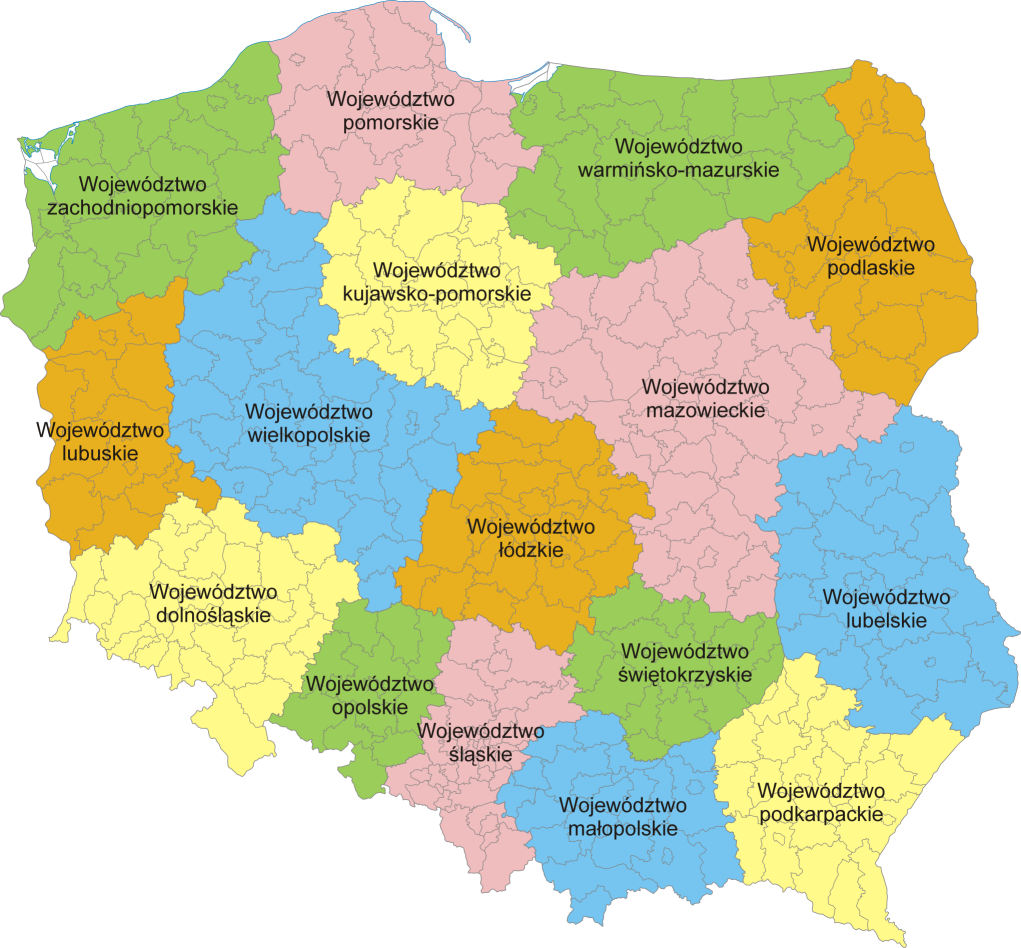

Let’s see if this tracks across countries and is not just a phenomenon
present in the United States. Poland politically is a similarly divided
nation with the more Eastern and Southern regions prefering conservative
candidates and the Western and Northern regions prefering more liberal
candidates. Below is displayed a Map of the 2023 Polish Parlimentary
elections. 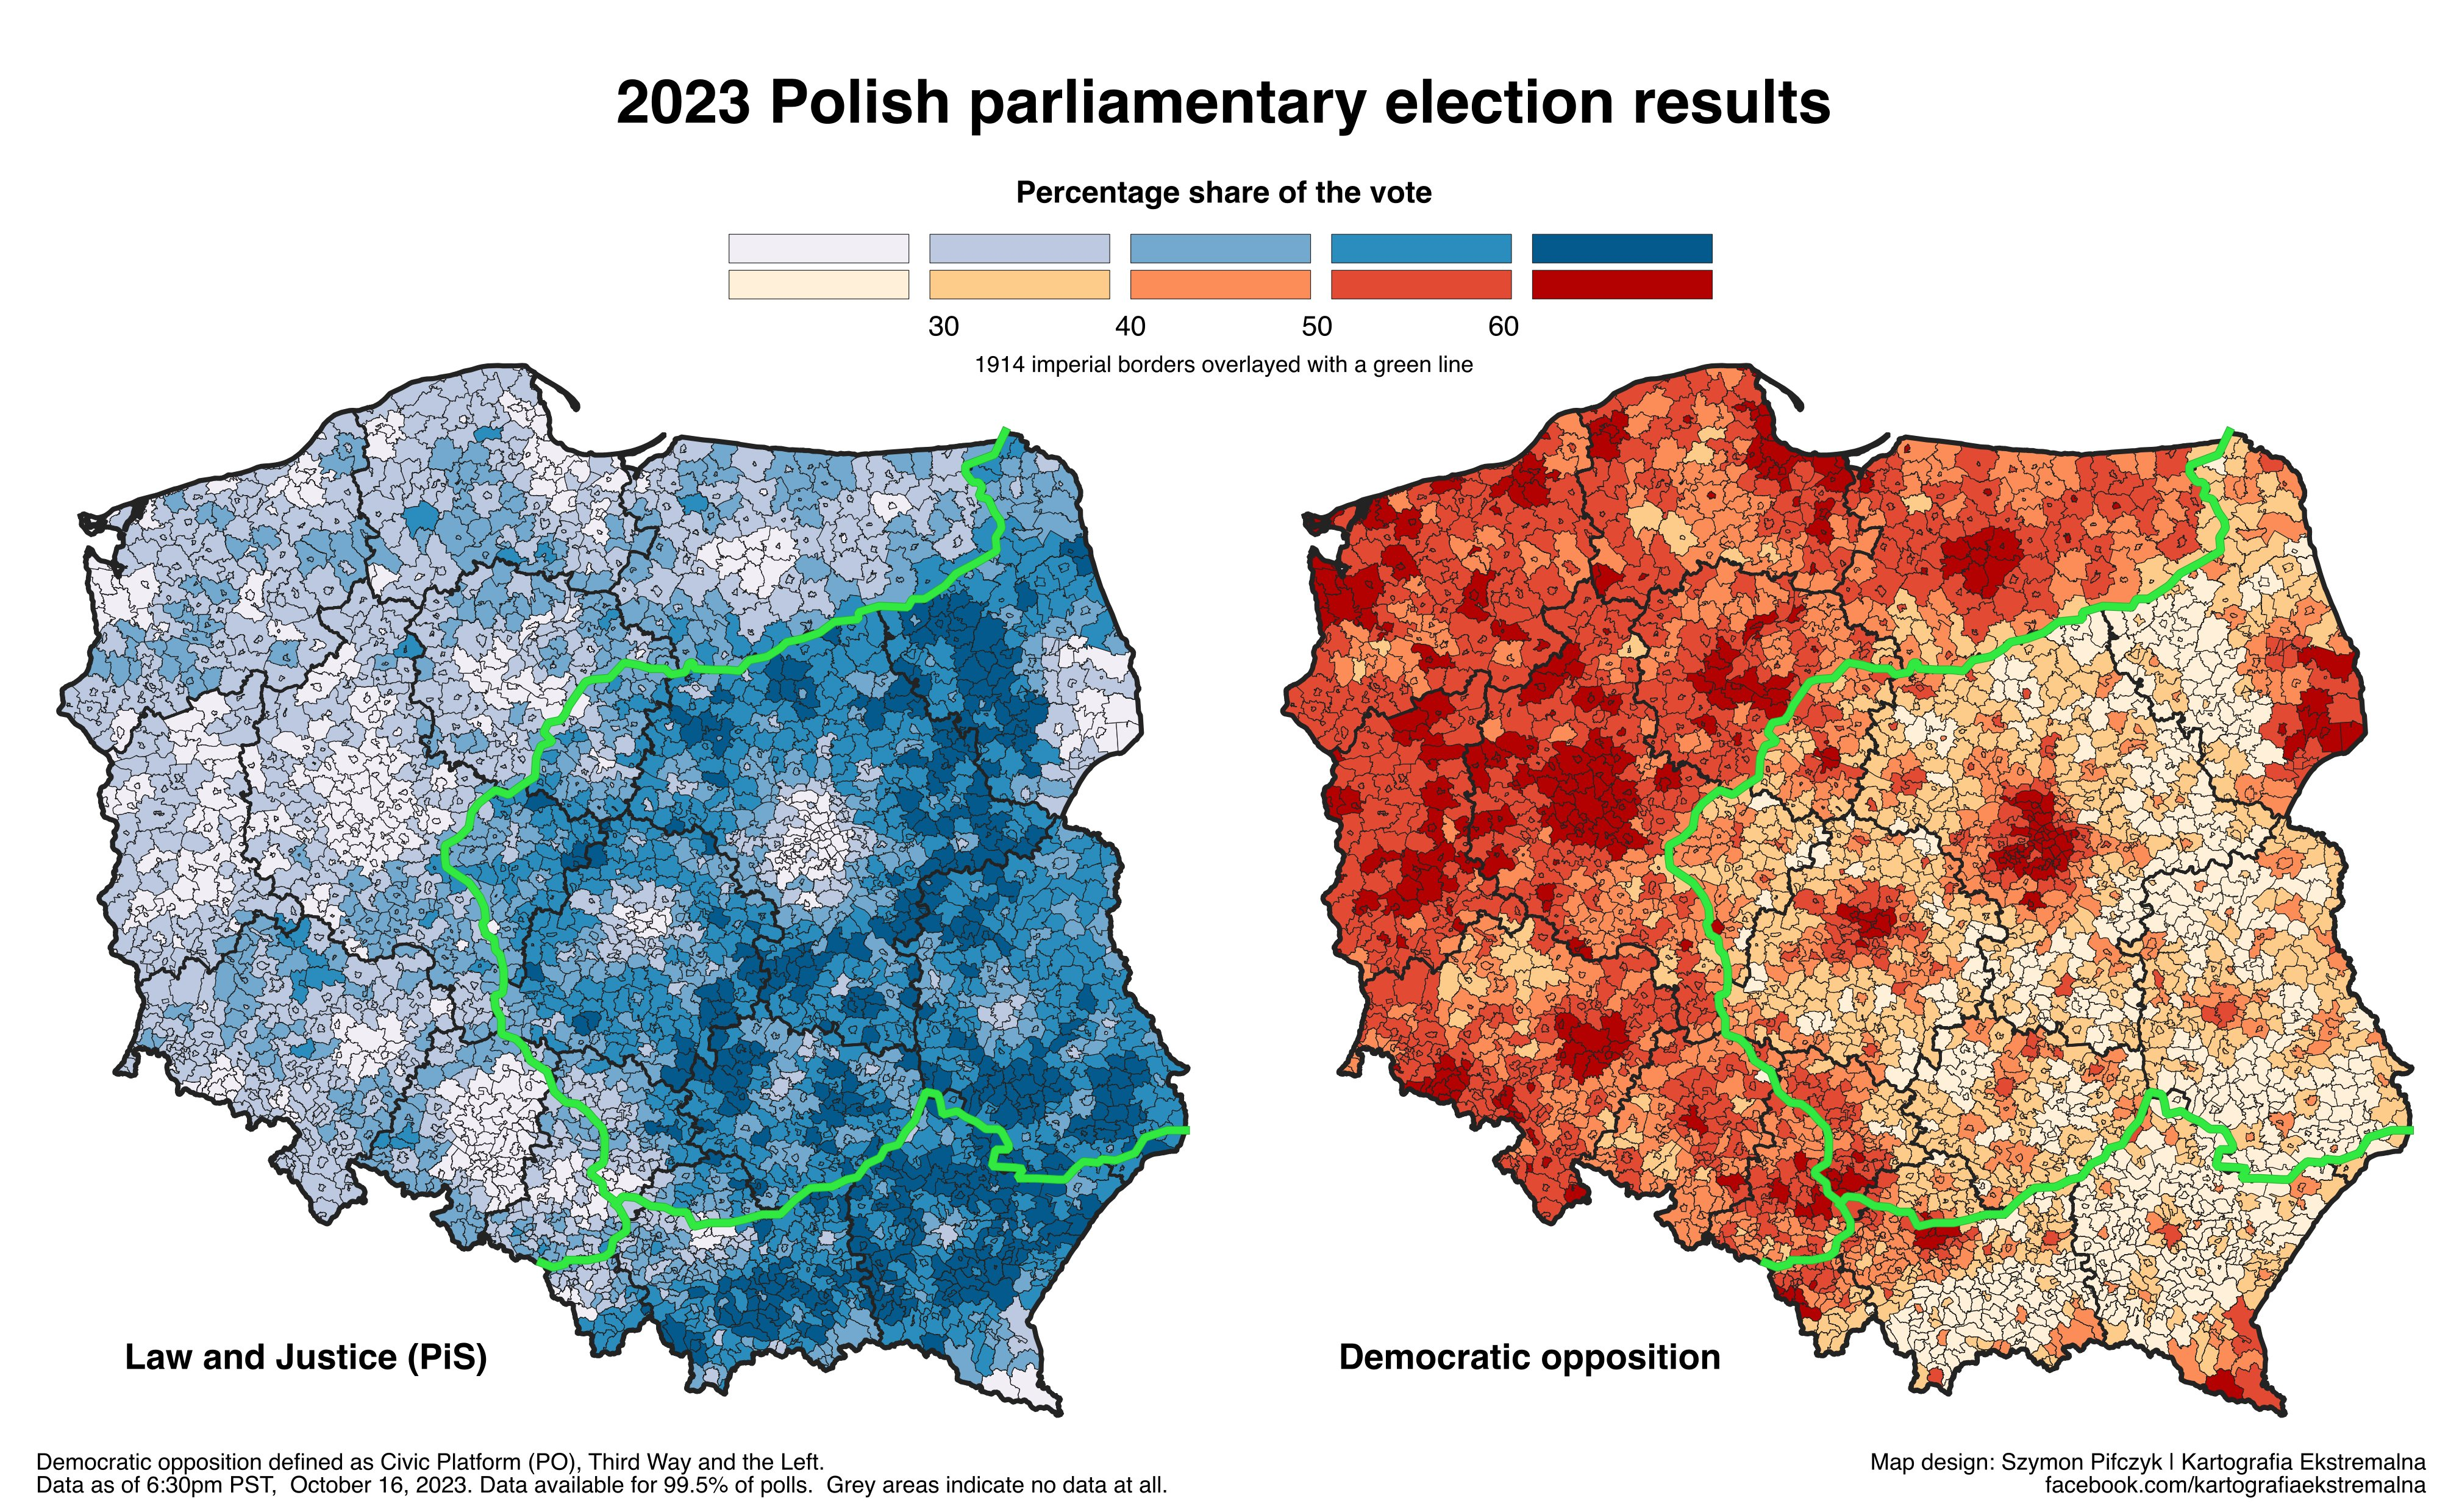 The Polish presidential
Election had it’s second round on June 1, 2025 and the this is the map
of the election. 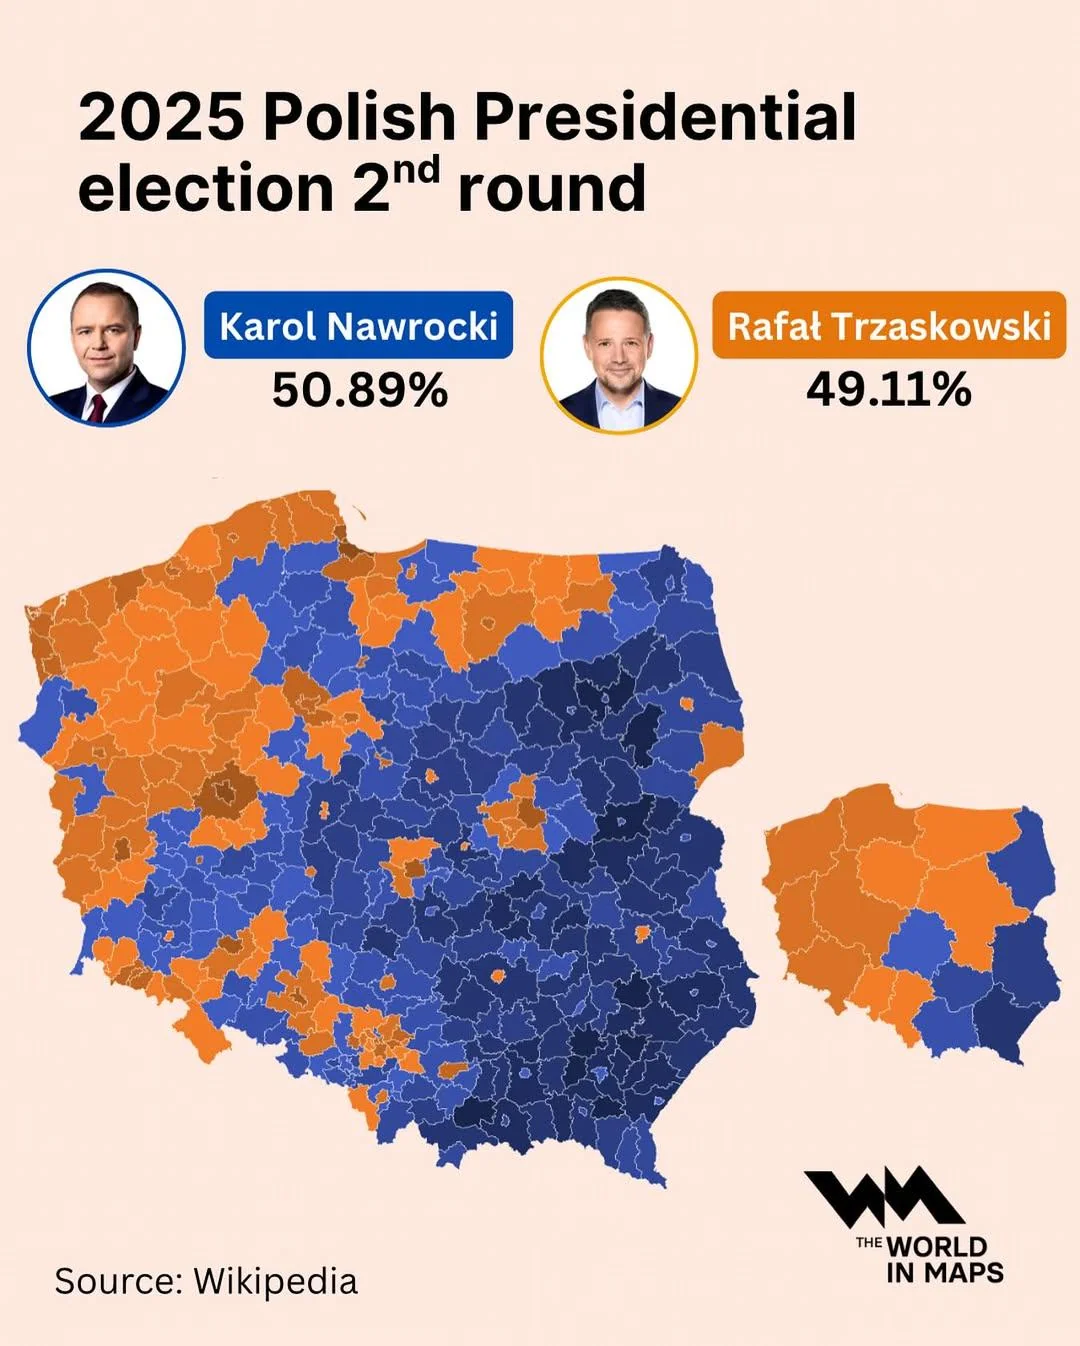 This general trend of
political allegiance has been around since Poland became independant
from the USSR in 1989. Following the analysis in the United States using
the Polish election results over the last 20 years the four most
left-leaning voivodeships are: Mazowieckie (Warsaw), Pomorskie
(Gdansk/Tri-city), Wielkopolskie (Poznan) and Zachodniopomorskie
(Szczeczin). The four most right-leaning voivodeships are: Podkarpackie
(Rzeszow/Przemysl) Lubelskie (Lublin), Podlaskie (Bialystok), and
Świętokrzyskie (Kielce). We will repeat the analysis for the United
States with these eight voivodeships.

In [14]:
poland_df = country_dfs['3. Poland'].copy()

# Define left-leaning and right-leaning voivodeships
left_leaning_voivodeships = [
    '7. Mazowieckie',  # Warsaw
    '11. Pomorskie',   # Gdansk/Tri-city
    '15. Wielkopolskie',  # Poznan
    '16. Zachodnio-Pomorskie'  # Szczeczin
]
right_leaning_voivodeships = [
    '9. Podkarpackie',  # Rzeszow/Przemysl
    '4. Lubelskie',     # Lublin
    '10. Podlaskie',    # Bialystok
    '13. Swietokrzyskie'  # Kielce
]

# Assign political group
def assign_voivodeship_group(voiv):
    if voiv in left_leaning_voivodeships:
        return 'Left-leaning'
    elif voiv in right_leaning_voivodeships:
        return 'Right-leaning'
    else:
        return 'Other'
poland_df['voivodeship_group'] = poland_df['anc_regpl'].apply(assign_voivodeship_group)

# Relationship normalization
relationship_colors = {
    'father': 'blue',
    'mother': 'pink',
    'brother': 'green',
    'sister': 'purple',
    'aunt': 'orange',
    'uncle': 'brown',
    'cousin': 'teal',
    'grandfather': 'navy',
    'grandmother': 'magenta',
    'son': 'red',
    'daughter': 'yellow',
    'nephew': 'lightgreen',
    'niece': 'lightpink',
    'stepfather': 'slateblue',
    'stepmother': 'plum',
    'other': 'gray',
}
def extract_relation_pl(rel_str):
    if not isinstance(rel_str, str):
        return 'other'
    rel_str = rel_str.lower()
    rel_str = re.sub(r'^\d+\.\s*', '', rel_str)
    for key in relationship_colors.keys():
        if key in rel_str:
            return key
    return 'other'
poland_df['relation'] = poland_df['kin_typ'].apply(extract_relation_pl)

# Metrics calculation
def calculate_metrics_pl(group_data):
    kin_counts = group_data.groupby('anc_id').size()
    avg_kin = kin_counts.mean() if not kin_counts.empty else 0
    children = group_data[group_data['relation'].isin(['son', 'daughter'])]
    children_count = children.groupby('anc_id').size()
    avg_children = children_count.mean() if not children_count.empty else 0
    cluster_sizes = kin_counts + 1  # Anchor + kin count
    avg_cluster_size = cluster_sizes.mean() if not cluster_sizes.empty else 0
    return avg_kin, avg_children, avg_cluster_size

# Calculate and print results
results_pl = {}
for group in ['Right-leaning', 'Left-leaning']:
    group_data = poland_df[poland_df['voivodeship_group'] == group]
    avg_kin, avg_children, avg_cluster_size = calculate_metrics_pl(group_data)
    results_pl[group] = {
        'avg_kin_per_anchor': avg_kin,
        'avg_children_per_anchor': avg_children,
        'avg_cluster_size': avg_cluster_size
    }

# Overall Poland
avg_kin, avg_children, avg_cluster_size = calculate_metrics_pl(poland_df)
results_pl['Overall Poland'] = {
    'avg_kin_per_anchor': avg_kin,
    'avg_children_per_anchor': avg_children,
    'avg_cluster_size': avg_cluster_size
}

# Print results
for group, metrics in results_pl.items():
    print(f"{group} Voivodeships:")
    print(f"  Avg kin per anchor: {metrics['avg_kin_per_anchor']:.2f}")
    #print(f"  Avg cluster size: {metrics['avg_cluster_size']:.2f}")
    print()

Just like with the United States the trend of right-leaning Voivodeships
having larger families is true. The average kin per anchor in
left-leaning regions is 18.54 and in righ-leaning regions is 20.85 a
difference of 2.31 which is larger than the 1.58 in the United States.

We should also test if these results are significant. To do this we will
use a t-test which you may be familiar with from any introductory
statistics class like STATS 200. A t-test measures the difference
between the means of two groups, taking into account the variability
within those groups. It helps determine if the observed difference is
statistically significant, meaning it’s unlikely to have occurred by
random chance.

### 6.3 Signifcance of these findings

We will first do our t-test for the United States.

In [15]:
from scipy import stats #library with statistical functions like t-test
# Extract US data from country_dfs and make a proper copy
us_data = country_dfs['10. USA'].copy()

# Map region names to political lean
democrat_regions = [
    '5. New England (CT, MA, ME, NH, RI, VT)',
    '6. Pacific (AK, CA, HI, OR, WA)',
    '3. Mid-Atlantic (NJ, NY, DE, PA)',
    '1. East North Central (IL, IN, MI, OH, WI)'
]

republican_regions = [
    '2. East South Central (AL, KY, MS, TN)',
    '9. West South Central (AR, LA, OK, TX)',
    '8. West North Central (IA, KS, MN, MO, NE, ND, SD)',
    '4. Mountain (AZ, CO, ID, MT, NV, NM, UT, WY)',
    '7. South Atlantic (FL, GA, MD, NC, SC, VA, WV, DC)'
]

# Assign group based on region
def assign_state_group(region):
    if region in democrat_regions:
        return 'Democrat'
    elif region in republican_regions:
        return 'Republican'
    else:
        return 'Other'

# Apply transformation
us_data['state_group'] = us_data['anc_regus'].apply(assign_state_group)

# Calculate kin counts per anchor for each political group
republican_kin_counts = us_data[us_data['state_group'] == 'Republican'].groupby('anc_id').size()
democrat_kin_counts = us_data[us_data['state_group'] == 'Democrat'].groupby('anc_id').size()

# Perform t-test for US data
us_t_stat, us_p_value = stats.ttest_ind(republican_kin_counts, democrat_kin_counts)

print(f"Republican regions - Sample size: {len(republican_kin_counts)}")
print(f"Republican regions - Mean kin per anchor: {republican_kin_counts.mean():.2f}")
print(f"Republican regions - Std deviation: {republican_kin_counts.std():.2f}")
print()
print(f"Democrat regions - Sample size: {len(democrat_kin_counts)}")
print(f"Democrat regions - Mean kin per anchor: {democrat_kin_counts.mean():.2f}")
print(f"Democrat regions - Std deviation: {democrat_kin_counts.std():.2f}")
print()
print(f"T-statistic: {us_t_stat:.4f}")
print(f"P-value: {us_p_value:.6f}")
print(f"Significant at α=0.05: {'Yes' if us_p_value < 0.05 else 'No'}") # main findings to be easy for students
print(f"Significant at α=0.01: {'Yes' if us_p_value < 0.01 else 'No'}") # main findings to be easy for students
print()

We find that for the United States both the Democrat and Republican
leaning regions have a large sample size and our findings are
significant at both 95% and 99% Confidence Intervals meaning that they
are likely not caused by random coincidence.

Let’s see if this trend continues in Poland.

In [16]:
poland_df = country_dfs['3. Poland'].copy()

# Define left-leaning and right-leaning voivodeships
left_leaning_voivodeships = [
    '7. Mazowieckie',  # Warsaw
    '11. Pomorskie',   # Gdansk/Tri-city
    '15. Wielkopolskie',  # Poznan
    '16. Zachodnio-Pomorskie'  # Szczeczin
]

right_leaning_voivodeships = [
    '9. Podkarpackie',  # Rzeszow/Przemysl
    '4. Lubelskie',     # Lublin
    '10. Podlaskie',    # Bialystok
    '13. Swietokrzyskie'  # Kielce
]

# Assign political group
def assign_voivodeship_group(voiv):
    if voiv in left_leaning_voivodeships:
        return 'Left-leaning'
    elif voiv in right_leaning_voivodeships:
        return 'Right-leaning'
    else:
        return 'Other'

poland_df['voivodeship_group'] = poland_df['anc_regpl'].apply(assign_voivodeship_group)

# Calculate kin counts per anchor for each political group
right_kin_counts = poland_df[poland_df['voivodeship_group'] == 'Right-leaning'].groupby('anc_id').size()
left_kin_counts = poland_df[poland_df['voivodeship_group'] == 'Left-leaning'].groupby('anc_id').size()

# Perform t-test for Poland data
poland_t_stat, poland_p_value = stats.ttest_ind(right_kin_counts, left_kin_counts)

print(f"Right-leaning voivodeships - Sample size: {len(right_kin_counts)}")
print(f"Right-leaning voivodeships - Mean kin per anchor: {right_kin_counts.mean():.2f}")
print(f"Right-leaning voivodeships - Std deviation: {right_kin_counts.std():.2f}")
print()
print(f"Left-leaning voivodeships - Sample size: {len(left_kin_counts)}")
print(f"Left-leaning voivodeships - Mean kin per anchor: {left_kin_counts.mean():.2f}")
print(f"Left-leaning voivodeships - Std deviation: {left_kin_counts.std():.2f}")
print()
print(f"T-statistic: {poland_t_stat:.4f}")
print(f"P-value: {poland_p_value:.6f}")
print(f"Significant at α=0.05: {'Yes' if poland_p_value < 0.05 else 'No'}")
print(f"Significant at α=0.01: {'Yes' if poland_p_value < 0.01 else 'No'}")
print()

We again find that for Poland both the left and right leaning regions
have a large enough sample size and our findings are significant at both
95% and 99% Confidence Intervals. Because the research is biased towards
educated people it makes sense that the right-leaning regions of Poland
have a smaller sample size as most of the educated people will be in
larger cities like Warsaw, Krakow or Gdansk (which are left-leaning).

More conservative regions in Poland have larger families by on average
2.31 people. This is even more significant than in the United States.

### 6.4 Discussion

For the next part of the notebook turn to a person next to you and
discuss these findings. Why do these more conservative regions have
larger families is is just more “traditional values,” or is there
something more? Use the frameworks discussed in class. This will be
easier for the United States as people are more familiar with politics
and life in the United States. But also try for Poland; this will be
more difficult.

# 7.0 Employment and Education in Poland

In this section, we analyze the regional patterns of education,
employment, and health across the Polish voivodeships, using our data
from the KINMATRIX dataset. By summarizing key demographic statistics
for each region, we can assess how the socioeconomic landscape of Poland
corresponds to established trends we take for granted in theory (for
example: larger cities are more educated and have higher employment
rates).

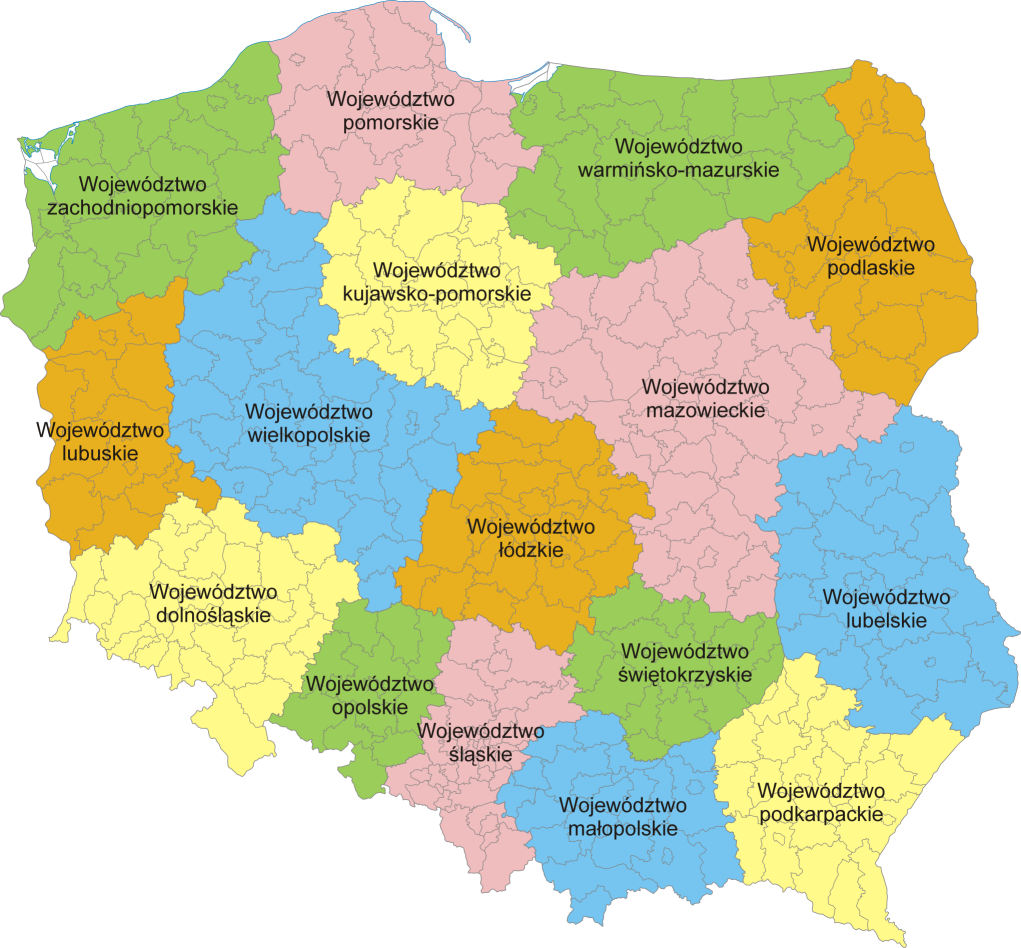

The cell below will filter the dataset for Poland and loop through all
the voivodeships.

In [17]:
# Filter for Poland
poland_df = df[df['anc_cou'] == '3. Poland']

# Get unique voivodeships
voivodeships = poland_df['anc_regpl'].dropna().unique()

# Loop through all voivodeships
for voiv in voivodeships:
    voiv_df = poland_df[poland_df['anc_regpl'] == voiv]
    print(f"Voivodeship: {voiv}, Number of Anchor Nodes: {len(voiv_df)}")

From the cell below we will get all of our summary statistics for each
voivodeship.

In [18]:
# List of variables
summary_vars = {
    'education': 'anc_eduall',                # Education (all countries)
    'education_poland': 'anc_edupl',          # Education (Poland-specific)
    'sexual_orientation': 'anc_sor',          # Sexual orientation
    'gender': 'anc_gnd',                      # Gender
    'income': 'anc_sss',                      # Subjective social status (income proxy)
    'age': 'anc_age',                         # Age
    'region': 'anc_regpl',                    # Voivodeship (region)
    'ethnicity': 'anc_eth',                   # Ethnicity
    'religion1': 'anc_rel1',                  # Religion (dummy for relgious)
    'religion2': 'anc_rel2',                  # Religion (which religion)
    'religion3': 'anc_rel3',                  # Religion (frequency/attendance)
    'employment': 'anc_emp',                  # Employment status
    'health': 'anc_hea',                      # Health
    'parental_separation': 'par_sep'          # Parental separation
}

def summarize_voivodeship(voiv_df):
    stats = {}
    # Network construction
    G = nx.Graph()
    for idx, row in voiv_df.iterrows():
        G.add_node(row['anc_id'], age=row['anc_age'], gender=row['anc_gnd'])
        kin_node = f"{row['anc_id']}_{row.get('kin_nam', 'unknown')}_{idx}"
        G.add_node(kin_node, relation=row.get('kin_typ', None))
        G.add_edge(row['anc_id'], kin_node)
    stats['nodes'] = G.number_of_nodes()
    stats['edges'] = G.number_of_edges()
    stats['density'] = nx.density(G)
    degrees = [deg for node, deg in G.degree()]
    stats['mean_degree'] = np.mean(degrees) if degrees else 0

    # Demographic summaries
    for label, var in summary_vars.items():
        value_counts = voiv_df[var].value_counts(dropna=False)
        stats[label] = value_counts.to_dict()
    return stats

# Filter for Poland and get unique voivodeships
poland_df = df[df['anc_cou'] == '3. Poland']
voivodeships = poland_df['anc_regpl'].dropna().unique()

# Loop through voivodeships and print summary
for voiv in voivodeships:
    voiv_df = poland_df[poland_df['anc_regpl'] == voiv]
    stats = summarize_voivodeship(voiv_df)
    print(f"\nVoivodeship: {voiv}")
    print(f"  Nodes: {stats['nodes']}")
    #print(f"  Edges: {stats['edges']}")
    #print(f"  Mean degree: {stats['mean_degree']:.2f}")
    print(f"  Education (all): {stats['education']}")
    print(f"  Education (Poland): {stats['education_poland']}")
    #print(f"  Sexual orientation: {stats['sexual_orientation']}")
    #print(f"  Gender: {stats['gender']}")
    #print(f"  Income (subjective social status): {stats['income']}")
    #print(f"  Age: {stats['age']}")
    #print(f"  Region: {stats['region']}")
    #print(f"  Ethnicity: {stats['ethnicity']}")
    #print(f"  Religion 1: {stats['religion1']}")
    #print(f"  Religion 2: {stats['religion2']}")
    #print(f"  Religion 3: {stats['religion3']}")
    print(f"  Employment: {stats['employment']}")
    print(f"  Health: {stats['health']}")
    #print(f"  Parental separation: {stats['parental_separation']}")

We will focus specifically on Education, Employment and Health. We will
then contrast this information to the Polish Census and discuss why
these differences exist very consistently across the voivodeships. If
there are other variables which you are interested in like Age or Sexual
orientation you can remove the **\#** before the print command for it to
show up in the cell output.

We have already looked at the variables education (all countries) and
health, but it is a good habit to look at all variables.

In the code block below we will look at Employment (anc_emp) and
Education Poland (anc_edupl) to examine the different levels these
variables can take.

In [19]:
# Filter for Poland
poland_df = df[df['anc_cou'] == '3. Poland']

# Get unique values for Polish education levels
edupl_levels = poland_df['anc_edupl'].dropna().unique()

# Get unique values for employment levels
emp_levels = poland_df['anc_emp'].dropna().unique()

print("Unique values for education_poland (anc_edupl):")
print(edupl_levels)

print("\nUnique values for employment (anc_emp):")
print(emp_levels)

We can already see a big difference between the variables education
(all) and education (Poland). The education all variable just has
qualitative levels (High, Medium, Low) while the Polish one has tangible
levels like Postgraduate, Secondary School or Doctorate. This variable
has an order which reflect the Polish Education system from incomplete
secondary to the highest, doctorate/post-doctorate.

The employment variable also has clear levels like Full-time employed,
Student or Unemployed. These categories are mutually exclusive and cover
the main labor force statuses, reflecting employment, unemployment,
studying, domestic and care work, retirement, and inability to work due
to health.

Let’s go back to our original statistics from above the output of the
cell above it is quite overwhelming, to make it easier we can sort from
highest to smallest percentage.

In [20]:
summary_vars = {
    'education': 'anc_eduall',
    'education_poland': 'anc_edupl',
    'sexual_orientation': 'anc_sor',
    'gender': 'anc_gnd',
    'income': 'anc_sss',
    'age': 'anc_age',
    'region': 'anc_regpl',
    'ethnicity': 'anc_eth',
    'religion1': 'anc_rel1',
    'religion2': 'anc_rel2',
    'religion3': 'anc_rel3',
    'employment': 'anc_emp',
    'health': 'anc_hea',
    'parental_separation': 'par_sep'
}

# Filter for Poland and get unique voivodeships
poland_df = df[df['anc_cou'] == '3. Poland']
voivodeships = poland_df['anc_regpl'].dropna().unique()

summary_results = {}

for voiv in voivodeships:
    voiv_df = poland_df[poland_df['anc_regpl'] == voiv]
    stats = {}
    # Network construction
    G = nx.Graph()
    for idx, row in voiv_df.iterrows():
        G.add_node(row['anc_id'], age=row['anc_age'], gender=row['anc_gnd'])
        kin_node = f"{row['anc_id']}_{row.get('kin_nam', 'unknown')}_{idx}"
        G.add_node(kin_node, relation=row.get('kin_typ', None))
        G.add_edge(row['anc_id'], kin_node)
    stats['nodes'] = G.number_of_nodes()
    stats['edges'] = G.number_of_edges()
    stats['density'] = nx.density(G)
    degrees = [deg for node, deg in G.degree()]
    stats['mean_degree'] = np.mean(degrees) if degrees else 0

    # Demographic summaries
    for label, var in summary_vars.items():
        value_counts = voiv_df[var].value_counts(dropna=False)
        stats[label] = value_counts.to_dict()
    summary_results[voiv] = stats

rows = []
for voiv, stats in summary_results.items():
    # Education: % High
    edu_counts = stats['education']
    high = edu_counts.get('3. High', 0)
    total_edu = sum([v for k, v in edu_counts.items() if isinstance(v, (int, float)) and k not in ['-2. Prefer not to answer']])
    pct_high_edu = high / total_edu if total_edu else 0

    # Employment: % Full-time or Part-time employed
    emp_counts = stats['employment']
    full_time = emp_counts.get('1. Full-time employed', 0)
    part_time = emp_counts.get('2. Part-time employed', 0)
    employed = full_time + part_time
    total_emp = sum([v for k, v in emp_counts.items() if isinstance(v, (int, float))])
    pct_employed = employed / total_emp if total_emp else 0

    # Health: % Very good or Good
    health_counts = stats['health']
    very_good = health_counts.get('1. Very good', 0)
    good = health_counts.get('2. Good', 0)
    healthy = very_good + good
    total_health = sum([v for k, v in health_counts.items() if isinstance(v, (int, float))])
    pct_healthy = healthy / total_health if total_health else 0

    # Number of nodes
    nodes = stats['nodes']

    # % not Heterosexual
    sex_counts = stats['sexual_orientation']
    hetero = sex_counts.get('1. Heterosexual', 0)
    total_sex = sum([v for k, v in sex_counts.items() if isinstance(v, (int, float))])
    pct_not_hetero = 1 - (hetero / total_sex) if total_sex else 0

    rows.append({
        'Voivodeship': voiv,
        'Education_High_pct': pct_high_edu,
        'Employment_Employed_pct': pct_employed,
        'Health_Healthy_pct': pct_healthy,
        'Nodes': nodes,
        'Pct_Not_Hetero': pct_not_hetero
    })

df_summary = pd.DataFrame(rows)

# Sort and display for each metric
metrics = [
    ('Education_High_pct', 'Education (High %)'),
    ('Employment_Employed_pct', 'Employment (Employed %)'),
    ('Health_Healthy_pct', 'Health (Very good or Good %)'),
    ('Nodes', 'Number of nodes'),
    ('Pct_Not_Hetero', '% not Heterosexual')
]
for col, label in metrics:
    print(f"\nSorted by {label} (descending):")
    display_cols = ['Voivodeship', col]
    print(df_summary.sort_values(col, ascending=False)[display_cols].to_string(index=False))

If we look at the variables of Education, Employment, and Health we can
gather which are the richest and healthiest voivodeships. The simplest
is employment which we can compare to the 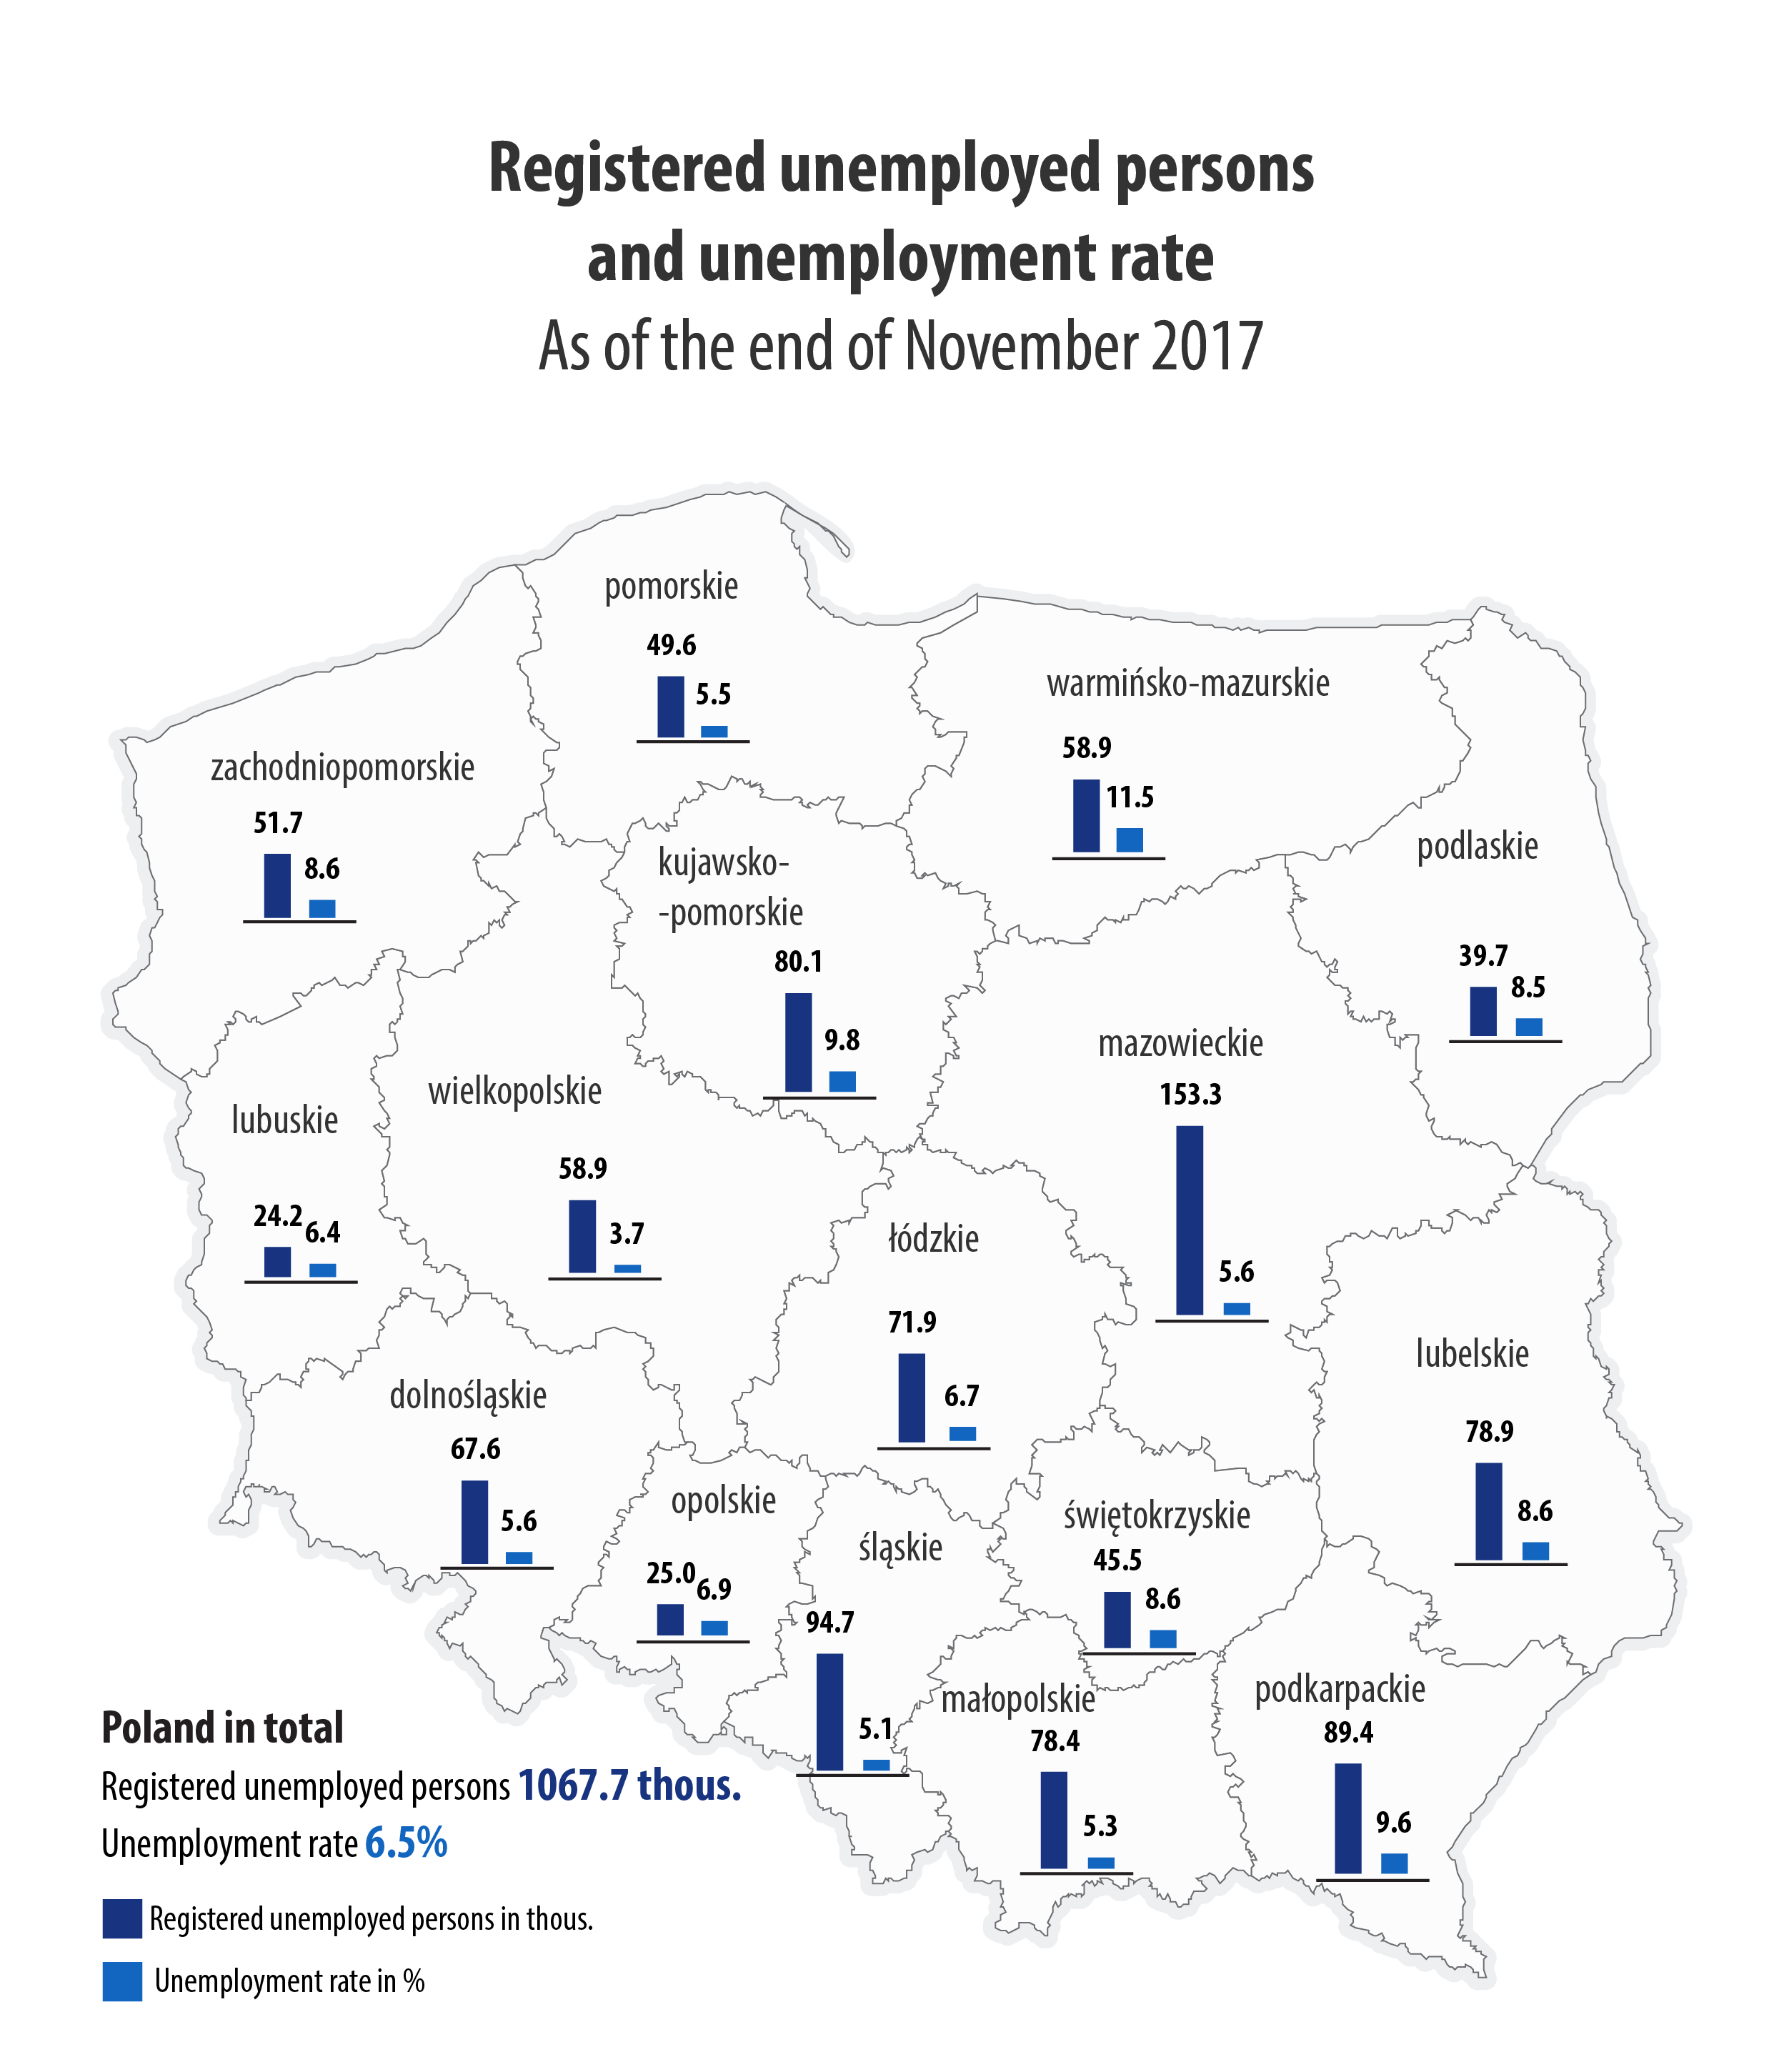
This map is from 2017 and from the Polish census we can see that the
lowest unemployment rates are in areas with large cities like the
Mazowieckie (Warsaw), Malopolskie (Krakow) and Pomorskie (Gdansk)
voivodeships. This makes sense as major cities bring opportunities.

Now let’s compare it to our KINMATRIX data, do these findings carry
over? Our three most employed voivodeship’s are: Zachodnio-Pomorskie
with 86.5%, Wielkopolskie with 81.8% and Dolnoslaskie with 81.5%. Our
three least employed are Opolskie with 71.4% Lubelskie with 69.5% and
Kujawsko-Pomorskie with 66.29%. Even with the far smaller sample size
these findings seem to be in-line with the census data and with
development/economic theory. The voivodeship’s with the lowest
employment all lack big cities Opole, Lublin and Bydgoszcz are all far
smaller than Szczecin, Poznan, and Wroclaw.

# 8.0 Parental Seperations

Let’s look at the Parental Seperation Variable.

In [21]:
print("Unique values for parental separation (par_sep):")
print(df['par_sep'].dropna().unique())

It is a simple indicator variable of if the anchor’s parents are
seperated.

We will look through all countries in our dataset looking at countries
and parental seperation for the parents of the anchor individual.

In [22]:
# Country mapping dictionary
country_map = {
    'UK': '1. UK',
    'Germany': '2. Germany',
    'Poland': '3. Poland',
    'Italy': '4. Italy',
    'Sweden': '5. Sweden',
    'Denmark': '6. Denmark',
    'Finland': '7. Finland',
    'Norway': '8. Norway',
    'Netherlands': '9. Netherlands',
    'USA': '10. USA'
}

# Initialize results storage
separation_results = {}

# Calculate percentages for each country
for country, code in country_map.items():
    country_df = df[df['anc_cou'] == code]
    
    # Parental separation calculation
    sep_counts = country_df['par_sep'].value_counts(dropna=True)
    separated = sep_counts.get('1. Yes', 0)  
    # Exclude 'Prefer not to answer' from total 
    valid_responses = sep_counts.drop('-2. Prefer not to answer', errors='ignore').sum()
    sep_pct = separated / valid_responses if valid_responses > 0 else 0
    separation_results[country] = sep_pct

# Sort results from most to least
sorted_separation_desc = sorted(separation_results.items(), key=lambda x: x[1], reverse=True)

# Prepare output string
separation_output = "Countries sorted by parental separation (highest to lowest rate):\n"

for country, pct in sorted_separation_desc:
    separation_output += f"{country}: {pct:.2%}\n"

print(separation_output)

Suprising results with Poland and Italy at the top, we would not expect
more traditional and Christian countries to have such a high divorce
rate. Let’s re-use the right and left leaning regions in Poland and see
if parental seperation differs by political allegiance.

In [23]:
# Left-/right-leaning voivodeship lists are defined as before.
left_leaning_voivodeships = [
    '7. Mazowieckie', '11. Pomorskie', '15. Wielkopolskie', '16. Zachodnio-Pomorskie'
]
right_leaning_voivodeships = [
    '9. Podkarpackie', '4. Lubelskie', '10. Podlaskie', '13. Swietokrzyskie'
]

poland_df = country_dfs['3. Poland'].copy()

# Assign the group using anc_regpl
def assign_voivodeship_group(voiv):
    if voiv in left_leaning_voivodeships:
        return 'Left-leaning'
    elif voiv in right_leaning_voivodeships:
        return 'Right-leaning'
    else:
        return 'Other'

poland_df['voivodeship_group'] = poland_df['anc_regpl'].apply(assign_voivodeship_group)

# Calculate parental separation per political group
sep_results = {}
for group in ['Left-leaning', 'Right-leaning', 'Other']:
    grp = poland_df[poland_df['voivodeship_group'] == group]
    counts = grp['par_sep'].value_counts(dropna=True)
    separated = counts.get('1. Yes', 0)
    valid = counts.drop('-2. Prefer not to answer', errors='ignore').sum()
    pct = separated / valid if valid > 0 else 0
    sep_results[group] = pct

# Print results
for group, pct in sep_results.items():
    print(f"{group}: {pct:.2%}")

We can see that there is no difference between left and right leaning
regions with the Left-leaning regions have a seperation percentage of
66.69% and the right leaning regions having one of 69.57%. So the cause
is not political leaning. Let us also repeat this analysis for the
United States.

USA Analysis of Political Allegiance

In [24]:
#American Regions from before
democrat_regions = [
    '5. New England (CT, MA, ME, NH, RI, VT)',
    '6. Pacific (AK, CA, HI, OR, WA)',
    '3. Mid-Atlantic (NJ, NY, DE, PA)',
    '1. East North Central (IL, IN, MI, OH, WI)'
]

republican_regions = [
    '2. East South Central (AL, KY, MS, TN)',
    '9. West South Central (AR, LA, OK, TX)',
    '8. West North Central (IA, KS, MN, MO, NE, ND...',  
    '4. Mountain (AZ, CO, ID, MT, NV, NM, UT, WY)',
    '7. South Atlantic (FL, GA, MD, NC, SC, VA, WV...'   
]


us_df = country_dfs['10. USA'].copy()

def assign_state_group(region):
    if region in democrat_regions:
        return 'Democrat'
    elif region in republican_regions:
        return 'Republican'

us_df['state_group'] = us_df['anc_regus'].apply(assign_state_group)

sep_results = {}
for group in ['Democrat', 'Republican']:
    grp = us_df[us_df['state_group'] == group]
    counts = grp['par_sep'].value_counts(dropna=True)
    separated = counts.get('1. Yes', 0)
    valid = counts.drop('-2. Prefer not to answer', errors='ignore').sum()
    pct = separated / valid if valid > 0 else 0
    sep_results[group] = pct

for group, pct in sep_results.items():
    print(f"{group} regions: {pct:.2%} had parental separation")

The pattern is different in the United States we can see that Democrat
regions have a far larger divorce rate than republican regions 52.59%
compared to 44.41%. This is a large difference, but can we dig deeper
into the reason for this difference. A possible reason for this could be
religion where Republicans are more likely to be Christian than
Democrats.

**Note**: Religion questions were deliberately excluded from European
KINMATRIX surveys, so we can not use it for our analysis of the European
countries. They were only included for the United States which makes it
perfect for this analysis.

We have three religious variables in the KINMATRIX Dataset: `anc_rel1`,
`anc_rel2`, and `anc_rel3`. Like with all variables, let’s look at all
the levels this variable can take.

In [25]:
print("Unique values for anc_rel1 (Religious dummy):")
print(df['anc_rel1'].dropna().unique())

print("\nUnique values for anc_rel2 (Religion ident.):")
print(df['anc_rel2'].dropna().unique())

print("\nUnique values for anc_rel3 (Attendance/frequency):")
print(df['anc_rel3'].dropna().unique())

From the output we can see that:

-   `anc_rel1` is a dummy variable for if the person is religious.
-   `anc_rel2` is a qualitative variable for which religion the person
    believe in.
-   `anc_rel3` is a variable for the frequency or attendace (how devout
    the person is).

In [26]:
def sep_rate(df):
    counts = df['par_sep'].value_counts(dropna=True)
    separated = counts.get('1. Yes', 0)
    # Exclude 'Prefer not to answer' from total
    valid = counts.drop('-2. Prefer not to answer', errors='ignore').sum()
    return (100 * separated / valid) if valid > 0 else 0

# 1. Proportion "Religious" (anc_rel1 == "1. Yes")
print("Religious Differences by Region")
rel1 = us_df[us_df['anc_rel1'] != '-3. Does not apply']    # Exclude "Does not apply"
for group in ['Democrat', 'Republican']:
    total = rel1[rel1['state_group'] == group].shape[0]
    religious = rel1[(rel1['state_group']==group) & (rel1['anc_rel1'] == '1. Yes')].shape[0]
    pct = 100 * religious / total if total else 0
    print(f"{group} regions: {pct:.1f}% report 'religious' (anc_rel1 == 'Yes')")
print()

# 2. Proportion attending at least monthly
freq_vals = {"1. Every day", "2. More than once a week", "3. Once a week", "4. At least once a month"}
print("Proportion attending religious services at least monthly:")
for group in ['Democrat', 'Republican']:
    sub = us_df[us_df['state_group'] == group]
    att = sub['anc_rel3'].isin(freq_vals).sum()
    total = sub['anc_rel3'].notna().sum()
    pct = 100*att/total if total else 0
    print(f"{group}: {pct:.1f}% attend services at least monthly")
print()

# 3. Parental separation by religion ("Yes"/"No") within each region
print("Parental separation by religious status within region:")
for group in ['Democrat','Republican']:
    for rel_flag in ['1. Yes','2. No']:
        sub = us_df[(us_df['state_group'] == group) & (us_df['anc_rel1'] == rel_flag)]
        pct = sep_rate(sub)
        print(f"{group} - Religious '{rel_flag}': {pct:.2f}% parental separation")
    print()

As we expected Republican regions are more relgious with 53% of the
respondents report that they are relgious, compared to 43% in Democrat
regions. Respondents from Republican regions also attend relgious
services more often (14.7% vs 11.7%).

What is suprising is that it seems that relgious families have a
significant higher percentage of parental seperation for both Democrat
and Republican leaning regions.

## 8.1 Discussion

The findings in this section are surprising. Please discuss these
findings in your group. Here are some possible topics for discussion:

-   Cross-national variation: Poland and Italy, which are often seen as
    more traditional and Christian countries show the highest parental
    separation rates in this dataset.
-   Poland has no difference in parental seperation based on political
    regions, but the United States does. Why is that?
-   How do we interpret the finding that within the US, ‘religious’
    families (by self-report) have higher parental separation than
    non-religious ones? Does anyone have any ideas as to why?

# 9.0 Non-Straight nodes across the countries and regions.

For the last part of this notebook let’s look at which countries have
the most straight and non-straight respondants. To do this we will use
the **anc_sor** variable. As with all variables let’s look at all the
values this variable can take.

In [27]:
print(df['anc_sor'].dropna().unique())

This variable records how respondents self-identify their sexual
orientation. The variable is categorical, with four possible responses:
Heterosexual, Gay or Lesbian, Bisexual and other.

Now let’s look through all the countries in the dataset looking for
least and most straight countries.

In [28]:
# Your country mapping dictionary
country_map = {
    'UK': '1. UK',
    'Germany': '2. Germany',
    'Poland': '3. Poland',
    'Italy': '4. Italy',
    'Sweden': '5. Sweden',
    'Denmark': '6. Denmark',
    'Finland': '7. Finland',
    'Norway': '8. Norway',
    'Netherlands': '9. Netherlands',
    'USA': '10. USA'
}

# Initialize results dictionary
orientation_results = {}

# Calculate percentages for each country and sexual orientation
for country, code in country_map.items():
    country_df = df[df['anc_cou'] == code]
    
    # Value counts including NaNs (if needed)
    sor_counts = country_df['anc_sor'].value_counts(dropna=True)
    # Optionally, exclude 'Prefer not to answer' category
    valid_counts = sor_counts.drop('-2. Prefer not to answer', errors='ignore')
    total = valid_counts.sum()
    
    # Calculate percentages for each orientation
    percentages = {k: (v / total) for k, v in valid_counts.items()} if total > 0 else {}
    orientation_results[country] = percentages

# Print results
for country, percentages in orientation_results.items():
    print(f"{country_map[country]}:")
    if not percentages:
        print("  No data")
        continue
    # Sort by most common orientation first
    sorted_orientations = sorted(percentages.items(), key=lambda x: x[1], reverse=True)
    for orientation, pct in sorted_orientations:
        print(f"  {orientation}: {pct:.2%}")
    print()  # Blank line between countries

Interesting findings: Poland has the highest percentage of people
identifying as heterosexual (92.21%), making it the most heterosexual
country in this set. Denmark has the lowest percentage identifying as
heterosexual (81.57%), and thus the highest percentage identifying as
non-heterosexual (18.43%).

### 9.1 Most Heterosexual and Non-Heterosexual regions in Poland and Denmark

We will look at the regions within each country that have the most
heterosexual and non-heterosexual respondants.

First Poland:

In [29]:
# For Poland: calculate percentages per voivodeship
poland_df = df[df['anc_cou'] == '3. Poland']
voivodeships = poland_df['anc_regpl'].dropna().unique()

region_hetero = {}

for region in voivodeships:
    region_df = poland_df[poland_df['anc_regpl'] == region]
    counts = region_df['anc_sor'].value_counts(dropna=True)
    counts = counts.drop('-2. Prefer not to answer', errors='ignore')
    total = counts.sum()
    pct_hetero = counts.get('1. Heterosexual', 0) / total if total > 0 else 0
    region_hetero[region] = pct_hetero

# Sort and print most and least heterosexual regions
most_hetero_region = max(region_hetero.items(), key=lambda x: x[1])
least_hetero_region = min(region_hetero.items(), key=lambda x: x[1])

print("Poland:")
print(f"Most heterosexual region: {most_hetero_region[0]} ({most_hetero_region[1]*100:.2f}%)")
print(f"Most non-heterosexual region: {least_hetero_region[0]} ({100 - least_hetero_region[1]*100:.2f}%)")

We can again consult our map of the Polish Voivodeships. 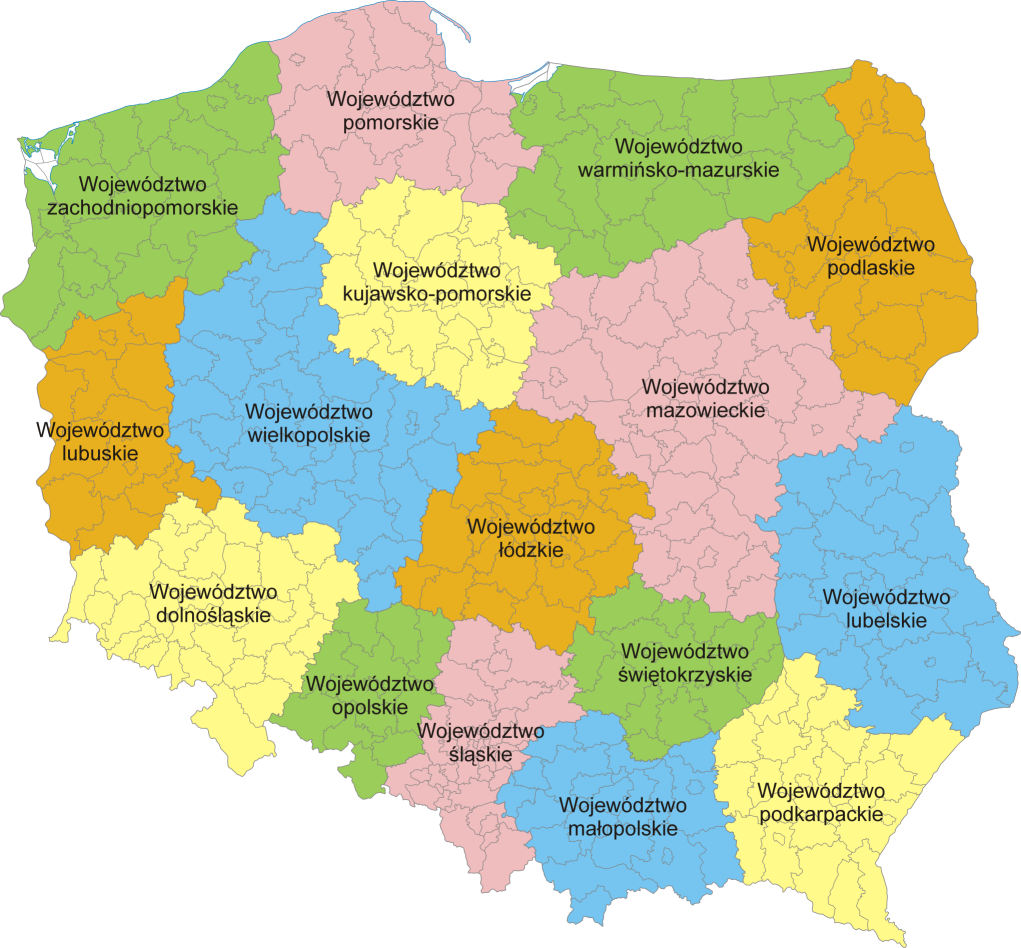 Opole is the smallest
and least populated voivodeship (province) of Poland. The province’s
name derives from that of the region’s capital and largest city, Opole.
Students should already be familiar with Pomerania (Pomorskie) as we
have already used and discussed this voievodeship in this notebook.
Pomorskie is in the north of Poland on the Baltic sea with the largest
city being Gdansk which is a large port along with Gdynia in the region.

Let’s now look at the findings in for Denmark:

In [30]:
# For Denmark: similar approach
denmark_df = df[df['anc_cou'] == '6. Denmark']
regions_dk = denmark_df['anc_regdk'].dropna().unique()

region_hetero_dk = {}

for region in regions_dk:
    region_df = denmark_df[denmark_df['anc_regdk'] == region]
    counts = region_df['anc_sor'].value_counts(dropna=True)
    counts = counts.drop('-2. Prefer not to answer', errors='ignore')
    total = counts.sum()
    pct_hetero = counts.get('1. Heterosexual', 0) / total if total > 0 else 0
    region_hetero_dk[region] = pct_hetero

# Sort and print most and least heterosexual regions
most_hetero_region_dk = max(region_hetero_dk.items(), key=lambda x: x[1])
least_hetero_region_dk = min(region_hetero_dk.items(), key=lambda x: x[1])

print("Denmark:")
print(f"Most heterosexual region: {most_hetero_region_dk[0]} ({most_hetero_region_dk[1]*100:.2f}%)")
print(f"Most non-heterosexual region: {least_hetero_region_dk[0]} ({100 - least_hetero_region_dk[1]*100:.2f}%)")

The most heterosexual region is Syddanmark which is the south of
Denmark.
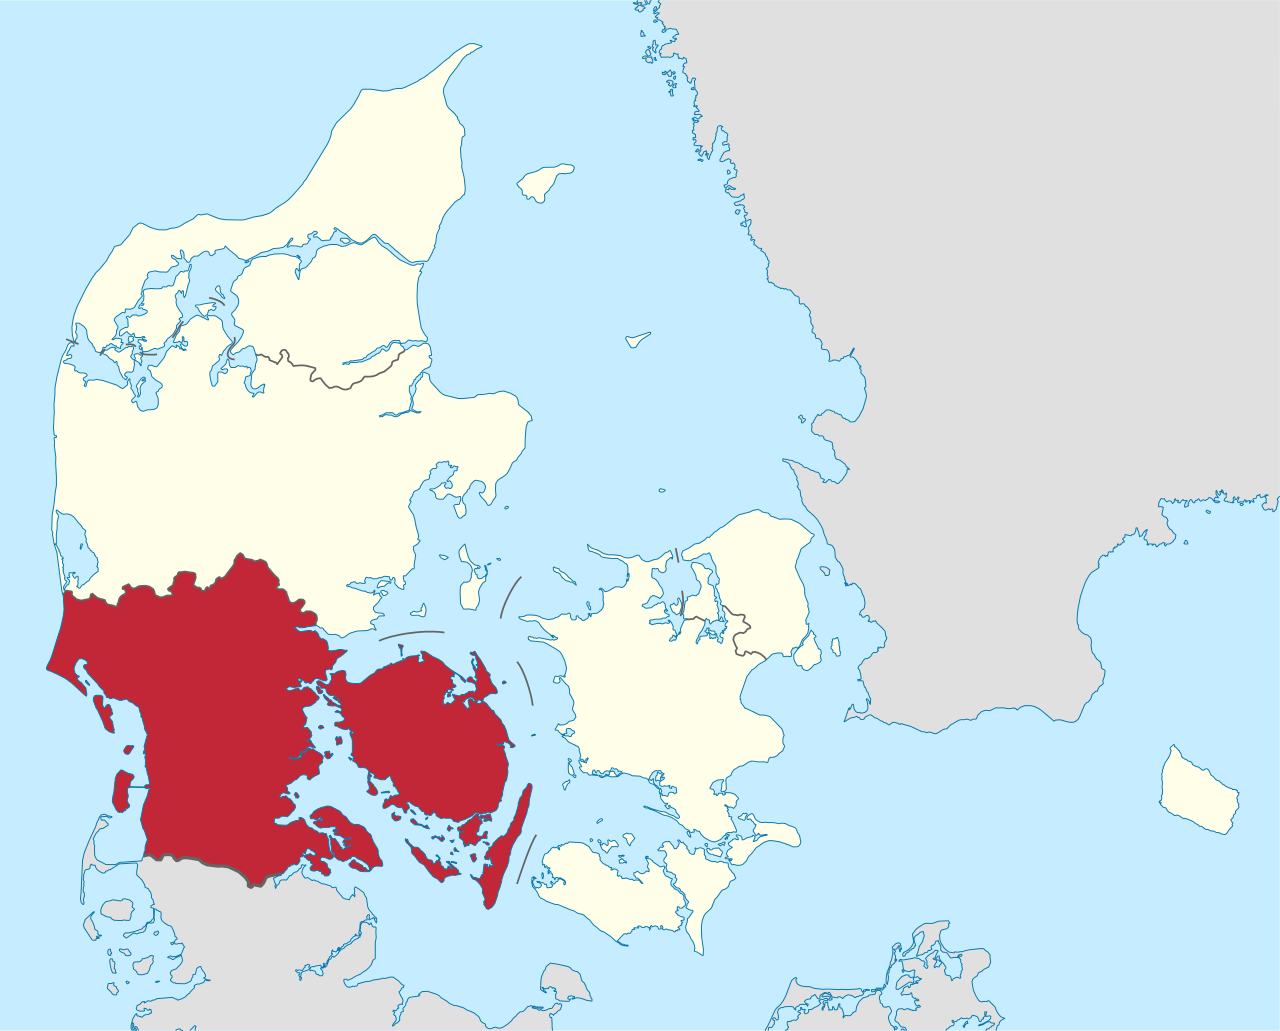 The
regional capital is Vejle but Odense is the region’s largest city.

As for the most non-heterosexual region it is Nordjylland which is the
north of Denmark.
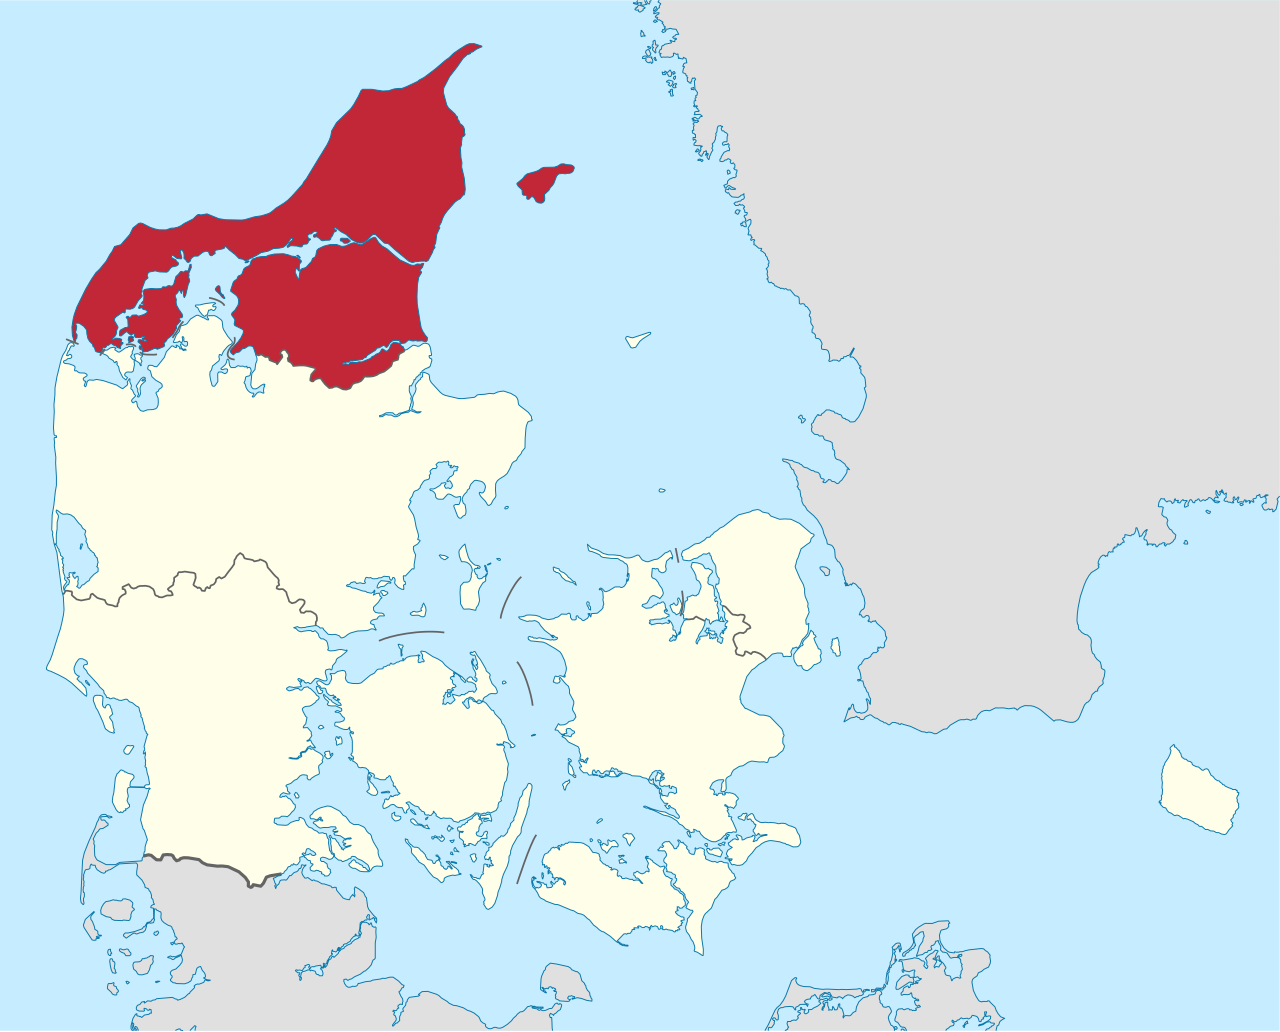 The largest
city in this region is Aalborg.

# 10.0 Hands on Section

For the next section students will be tasked with working hands on with
networks and performing the same data gathering as the researchers at
KINMATRIX. Turn to the person next to you and on a piece of paper or a
computer program like MSPaint draw their family network. Ask questions
about family relation, age, gender and other demographic variables like
education. Help each other and if you need an example look at the Pyvis
visualizations.

Alternatively students can plot their own family networks on our [Custom
Ego-Network Build Website](https://alexr951.github.io/EgoNetworkApp/).

# 11.0 Citations

Al-Taie, M. Z., & Kadry, S. (2017). *Python for graph and network
analysis*. Springer. https://doi.org/10.1007/978-3-319-53004-8

Brown, Kristen  V. “The Coming Democratic Baby Bust.” The Atlantic
Archive, 17 Feb. 2025, archive.is/pKsPn#selection-723.0-723.16.

“Cook Partisan Voting Index.” Wikipedia, Wikimedia Foundation, 25 May
2025, en.wikipedia.org/wiki/Cook_Partisan_Voting_Index.

Cox, Kimberley. “Feminist Theory in Sociology: EBSCO.” EBSCO Information
Services, Inc. \| Www.Ebsco.Com, 2021,
www.ebsco.com/research-starters/womens-studies-and-feminism/feminist-theory-sociology.

Dolan, Eric  W. “Research Reveals Widening Gap in Fertility Desires
between Republicans and Democrats.” PsyPost, 7 Oct. 2024,
www.psypost.org/research-reveals-widening-gap-in-fertility-desires-between-republicans-and-democrats/.

Graves, Jonathan, et al. “Network Analysis for Anthropolgy.” COMET, UBC,
2024, comet.arts.ubc.ca.

“Home.” Kinmatrix, 10 Apr. 2025, kinmatrix.eu/.

Kinmatrix: A New Data Resource for Studies of Families …,
www.demographic-research.org/volumes/vol51/25/51-25.pdf. Accessed 8
Aug. 2025.

Krisch, Joshua  A. “This Shocking Map Shows Republicans’ Most Powerful
Political Weapon.” Fatherly, 8 July 2022,
www.fatherly.com/health/republicans-have-more-children.

QuantEcon DataScience. (n.d.). *Social and economic networks*.
https://datascience.quantecon.org/applications/networks.html

“Registered Unemployed Persons and Unemployment Rate by Voivodships,
Subregions and Powiats. as of the End of November 2017.” Stat.Gov.Pl,
Government of Poland, 22 Dec. 2017,
stat.gov.pl/en/topics/labour-market/registered-unemployment/registered-unemployed-persons-and-unemployment-rate-by-voivodships-subregions-and-powiats-as-of-the-end-of-november-2017,1,64.html.

Nomaguchi, K. M. & Milkie, M. A. (2003). The costs and rewards of
children: The effect of becoming a parent on adults’ lives. Journal of
Marriage and Family, 65 (2), 356-374. link:
http://www.jstor.org/stable/3600082?pq-origsite=summon

Sayama, H. (2024, April 30). *Generating random graphs*. In
*Introduction to the modeling and analysis of complex systems*.
Mathematics LibreTexts.
https://math.libretexts.org/Bookshelves/Scientific_Computing_Simulations_and_Modeling/
Introduction_to_the_Modeling_and_Analysis_of_Complex_Systems\_(Sayama)/15%3A_Basics_of_Networks/15.06%3A_Generating_Random_Graphs